# Regression
---

## Funciones dumy

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Tuple
from matplotlib.axes import Axes
from matplotlib.figure import Figure
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
import numbers
import tabulate
from IPython.display import HTML, display


def print_tabulate(df: pd.DataFrame):
    display(HTML(tabulate(df, headers=df.columns, tablefmt="html")))
    
def transform_variable(df: pd.DataFrame, x:str) -> pd.DataFrame:
    """
    Transforma una variable a numérica si no lo es ya.
    
    Args:
    df (pd.DataFrame): El DataFrame de entrada.
    x (str): El nombre de la columna a transformar.
    
    Returns:
    pd.Series: La serie transformada.
    """
    if isinstance(df[x][0], numbers.Number):
        return df[x]
    else:
        return pd.DataFrame([i for i in range(0, len(df[x]))])

def split_train_test(df: pd.DataFrame, x_label: str, y_label: str, test_size: float = 0.3, random_state: int = 0) -> Tuple:
    """
    Divide los datos en conjuntos de entrenamiento y prueba.
    
    Args:
    df (pd.DataFrame): El DataFrame de entrada.
    x_label (str): El nombre de la columna de características.
    y_label (str): El nombre de la columna objetivo.
    test_size (float): La proporción del conjunto de datos a incluir en la división de prueba.
    random_state (int): Controla la aleatorización aplicada a los datos antes de aplicar la división.
    
    Returns:
    Tuple: X_train, X_test, y_train, y_test
    """
    fixed_x = transform_variable(df, x_label)
    return train_test_split(fixed_x, df[y_label], test_size=test_size, random_state=random_state)

def train_model(X, y, model_class: type[BaseEstimator], model_params: Dict[str, Any] = None) -> BaseEstimator:
    """
    Entrena un modelo con los parámetros dados.
    
    Args:
    X: Los datos de características.
    y: Los datos objetivo.
    model_class: La clase del modelo a entrenar.
    model_params: Parámetros para el modelo.
    
    Returns:
    BaseEstimator: El modelo entrenado.
    """
    print(f"Usando {model_class.__name__} con parámetros {model_params or 'por defecto'}")
    model = model_class(**(model_params or {}))
    return model.fit(X, y)

def create_plot(subplots: int = 111) -> Tuple[Figure, Axes]:
    """Crea una figura y ejes de matplotlib."""
    fig = plt.figure(figsize=(27, 18))
    ax = fig.add_subplot(subplots)
    return fig, ax

def plot_points(ax: Axes, x, y, scatter_params: Dict[str,Any]):
    """Dibuja puntos de dispersión en los ejes dados."""
    return ax.scatter(x, y, **scatter_params)

def plot_line(ax: Axes, x, y, **line_params):
    """Dibuja una línea en los ejes dados."""
    return ax.plot(x, y, **line_params)

def finalize_plot(fig: Figure, ax: Axes, file_name: str, ylim=None, x_rotation: int = 90):
    """Finaliza y guarda el gráfico."""
    ax.tick_params(axis='x', labelrotation=x_rotation)
    if ylim:
        ax.set_ylim(ylim)
    ax.legend(loc="upper left")
    fig.tight_layout()
    fig.savefig(file_name)
    plt.show()
    plt.close(fig)

def prepare_data() -> pd.DataFrame:
    """
    Prepara los datos para el análisis.
    
    Returns:
    pd.DataFrame: DataFrame procesado con fecha y salario neto total.
    """
    df = pd.read_csv("../csv/typed_uanl.csv")
    df_by_sal = df.groupby("Fecha")["Sueldo Neto"].sum().reset_index()
    df_by_sal.columns = ['Fecha', 'sueldo_neto_sum']
    return df_by_sal

## Función smart

In [18]:
from sklearn.linear_model import LinearRegression

def linear_regression_model(df: pd.DataFrame, x: str, y: str) -> None:
    """
    Realiza una regresión lineal y grafica los resultados.
    
    Args:
    df (pd.DataFrame): El DataFrame de entrada.
    x (str): El nombre de la columna de características.
    y (str): El nombre de la columna objetivo.
    """
    X = transform_variable(df, x)
    y_data = df[y]
    
    model = train_model(X, y_data, LinearRegression)
    
    print(f"Coeficientes: {model.coef_[0]:.4f}")
    print(f"Intercepto: {model.intercept_:.4f}")
    print(f"Media de {y}: {y_data.mean():.4f}")
    print(f"Puntuación R-cuadrado: {model.score(X, y_data):.4f}")
    
    fig, ax = create_plot()
    plot_points(ax, X, df[y], scatter_params={'marker':'.', 'c':'blue', 'label':'Puntos de datos'})
    plot_line(ax, df[x], model.predict(X), color='red', label='Línea de regresión')
    plot_line(ax, df[x], [y_data.mean()] * len(df), color='orange', label='Media')
    
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Regresión Lineal: {y} vs {x}')
    
    finalize_plot(fig, ax, f'../img/regresion/lineal/lr_{y}_{x}.png', ylim=[y_data.min(), y_data.max()])


# Líneal
---

## Ejecución de prueba de regresión

Usando LinearRegression con parámetros por defecto
Coeficientes: 1227923.2997
Intercepto: 159905731.3168
Media de sueldo_neto_sum: 188761928.8602
Puntuación R-cuadrado: 0.2980


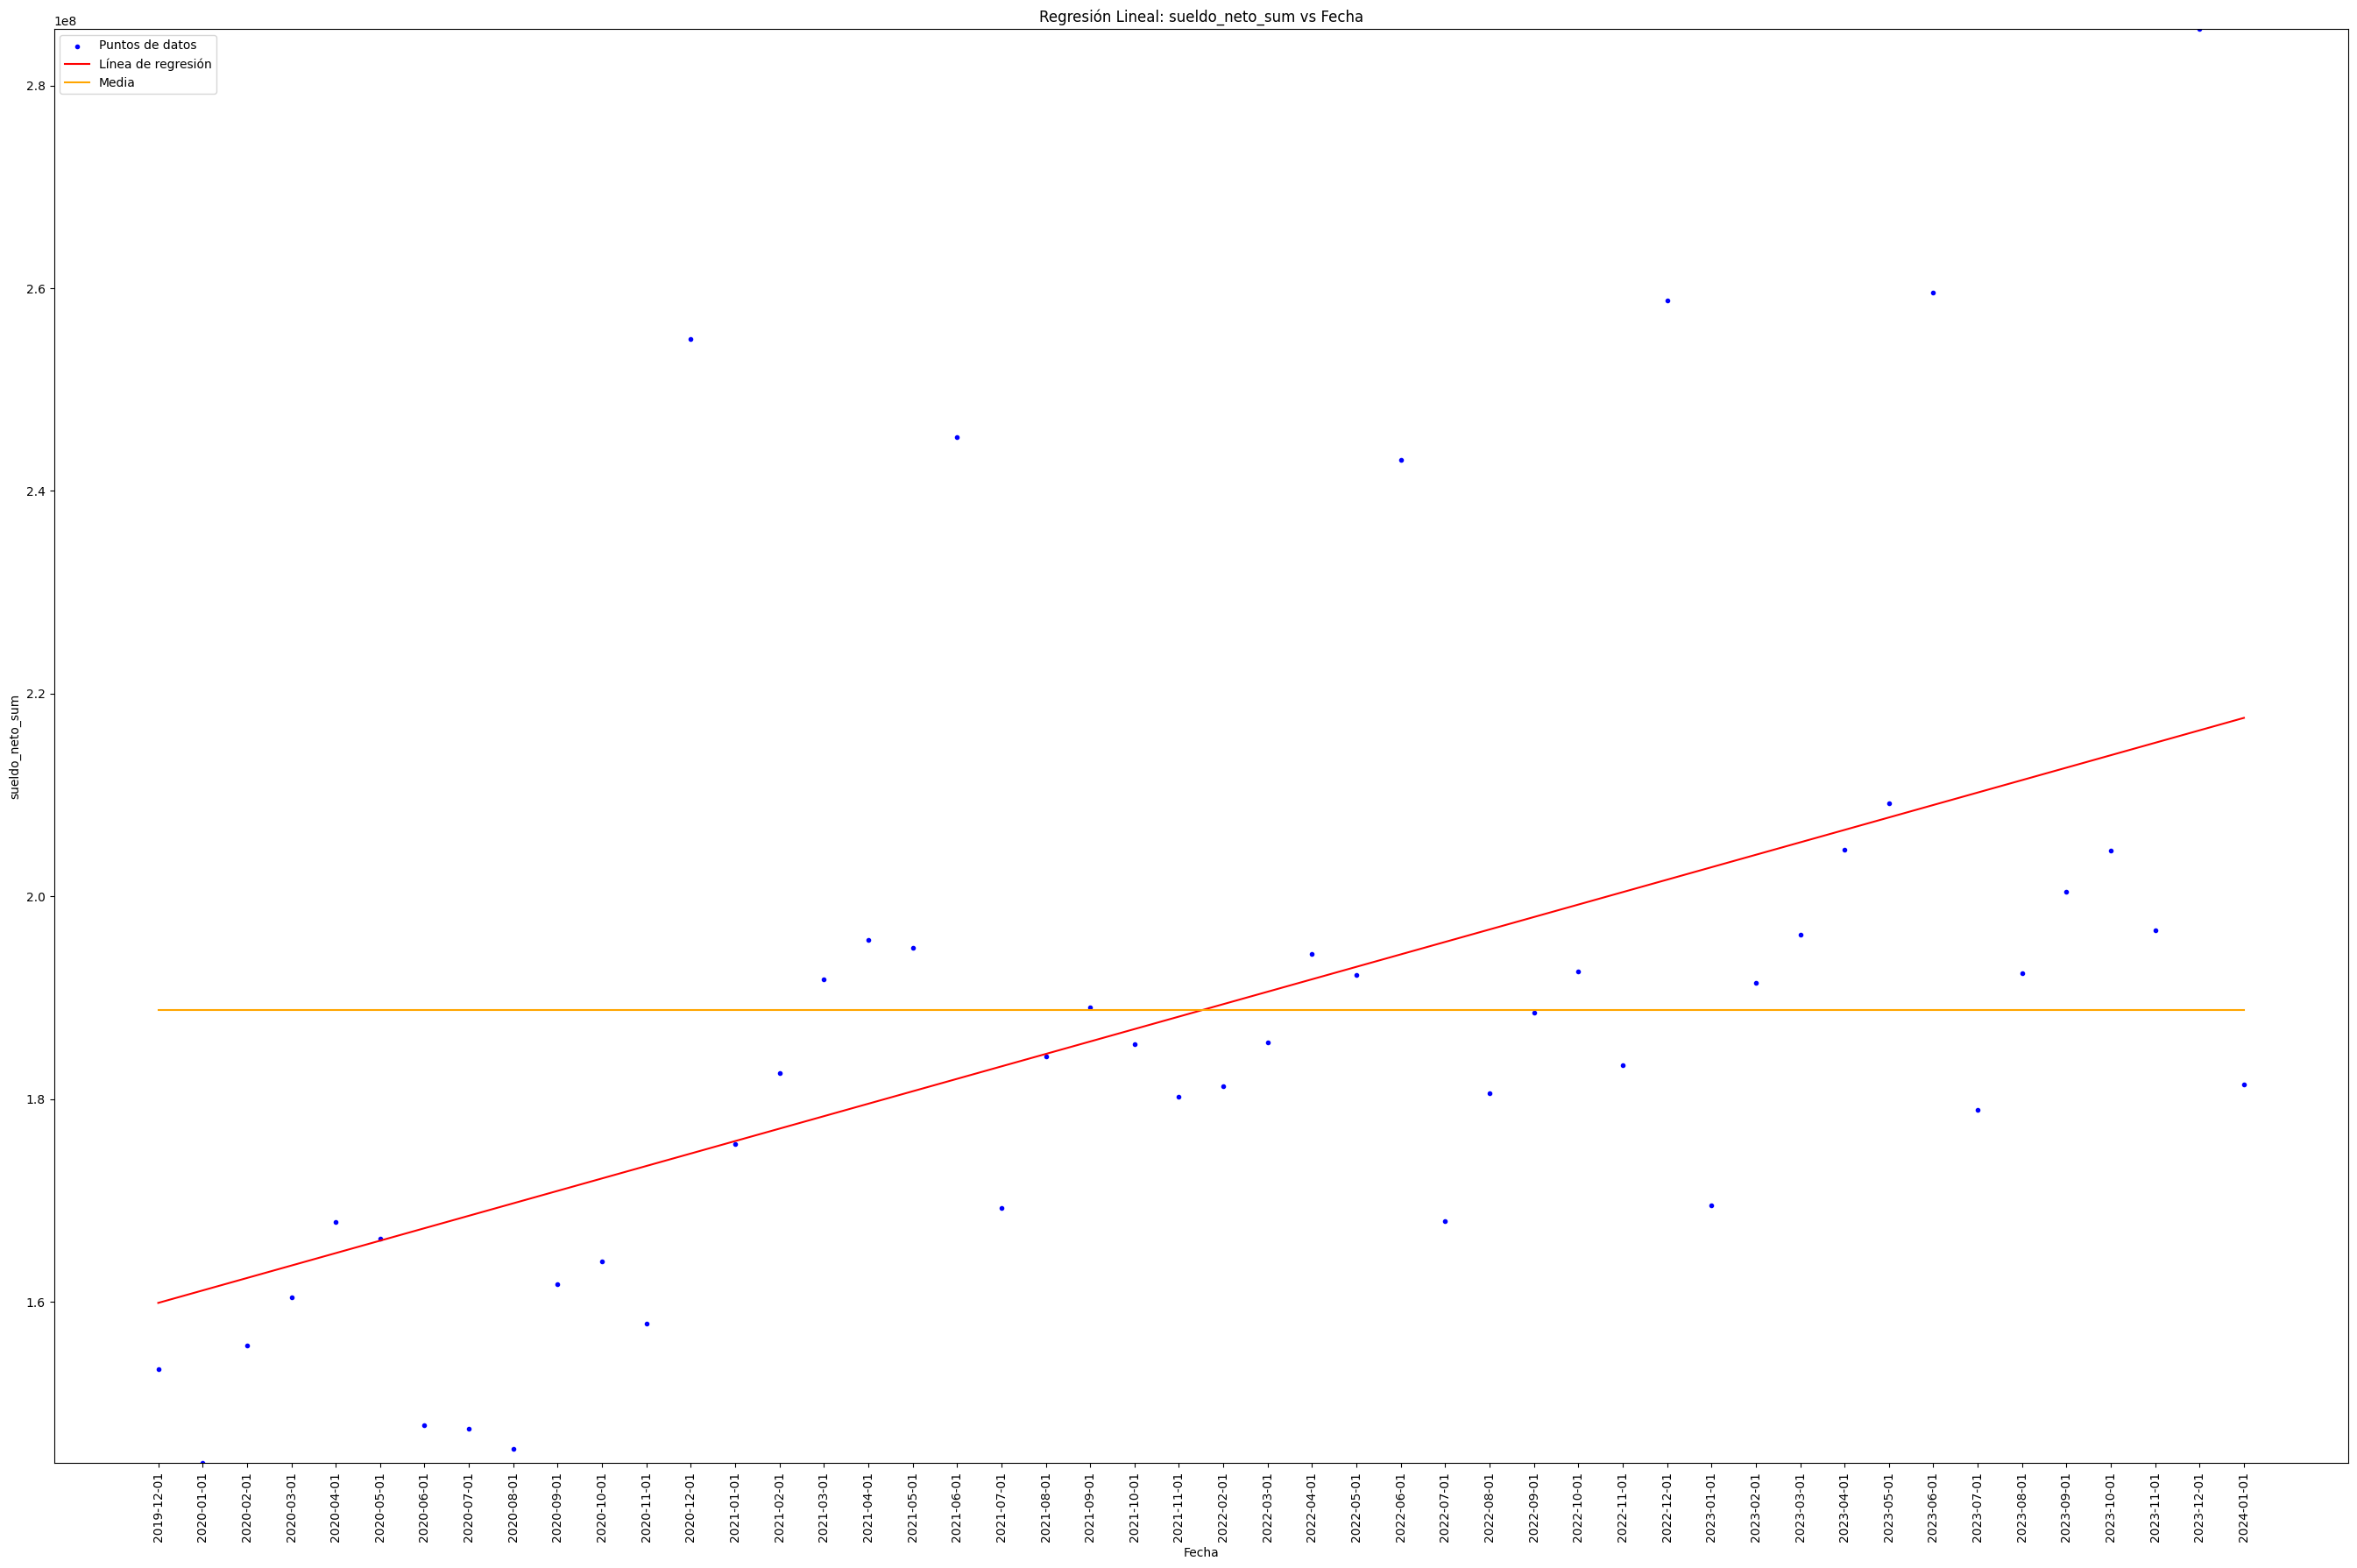

In [19]:
df_by_sal = prepare_data()
linear_regression_model(df_by_sal, "Fecha", "sueldo_neto_sum")

## Regresión con ridge

In [20]:
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

def linear_regression_ridge_model(df: pd.DataFrame, x: str, y: str, alphas: List[int]) -> None:
    """
    Realiza una regresión Ridge con diferentes valores de alpha y grafica los resultados.

    Args:
    df (pd.DataFrame): El DataFrame de entrada.
    x (str): El nombre de la columna de características.
    y (str): El nombre de la columna objetivo.
    alphas (List[int]): Lista de valores alpha para la regresión Ridge.
    """
    X = transform_variable(df, x).values.reshape(-1, 1)
    y_data = df[y]

    fig, ax = plt.subplots(figsize=(27, 18))
    
    # Graficar puntos de datos
    ax.scatter(df[x], y_data, marker='.', c='blue', label='Puntos de datos')

    # Realizar regresión Ridge para cada alpha
    for i, alpha in enumerate(alphas):
        model = train_model(X, y_data, Ridge, {'alpha': alpha})
        y_pred = model.predict(X)
        ax.plot(df[x], y_pred, color=f"C{i}", label=f"alpha {alpha}")
        print(f"alpha: {alpha}, coeficientes: {model.coef_[0]:.4f}, intercepto: {model.intercept_:.4f}")

    # Graficar la media
    mean = y_data.mean()
    ax.axhline(y=mean, color=f"C{len(alphas)}", label='Media', linestyle='--')

    # Configurar el gráfico
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Regresión Ridge: {y} vs {x}')
    ax.legend(loc="upper left")
    ax.tick_params(axis='x', rotation=90)
    
    # Ajustar los límites del eje y
    ax.set_ylim([y_data.min(), y_data.max()])

    # Guardar el gráfico
    plt.tight_layout()
    plt.savefig(f'../img/regresion/lineal/lr_ridge_{y}_{x}.png')
    plt.show()
    plt.close(fig)

Usando Ridge con parámetros {'alpha': 0}
alpha: 0, coeficientes: 1227923.2997, intercepto: 159905731.3168
Usando Ridge con parámetros {'alpha': 1000}
alpha: 1000, coeficientes: 1107680.1250, intercepto: 162731445.9215
Usando Ridge con parámetros {'alpha': 10000}
alpha: 10000, coeficientes: 588779.3794, intercepto: 174925613.4443


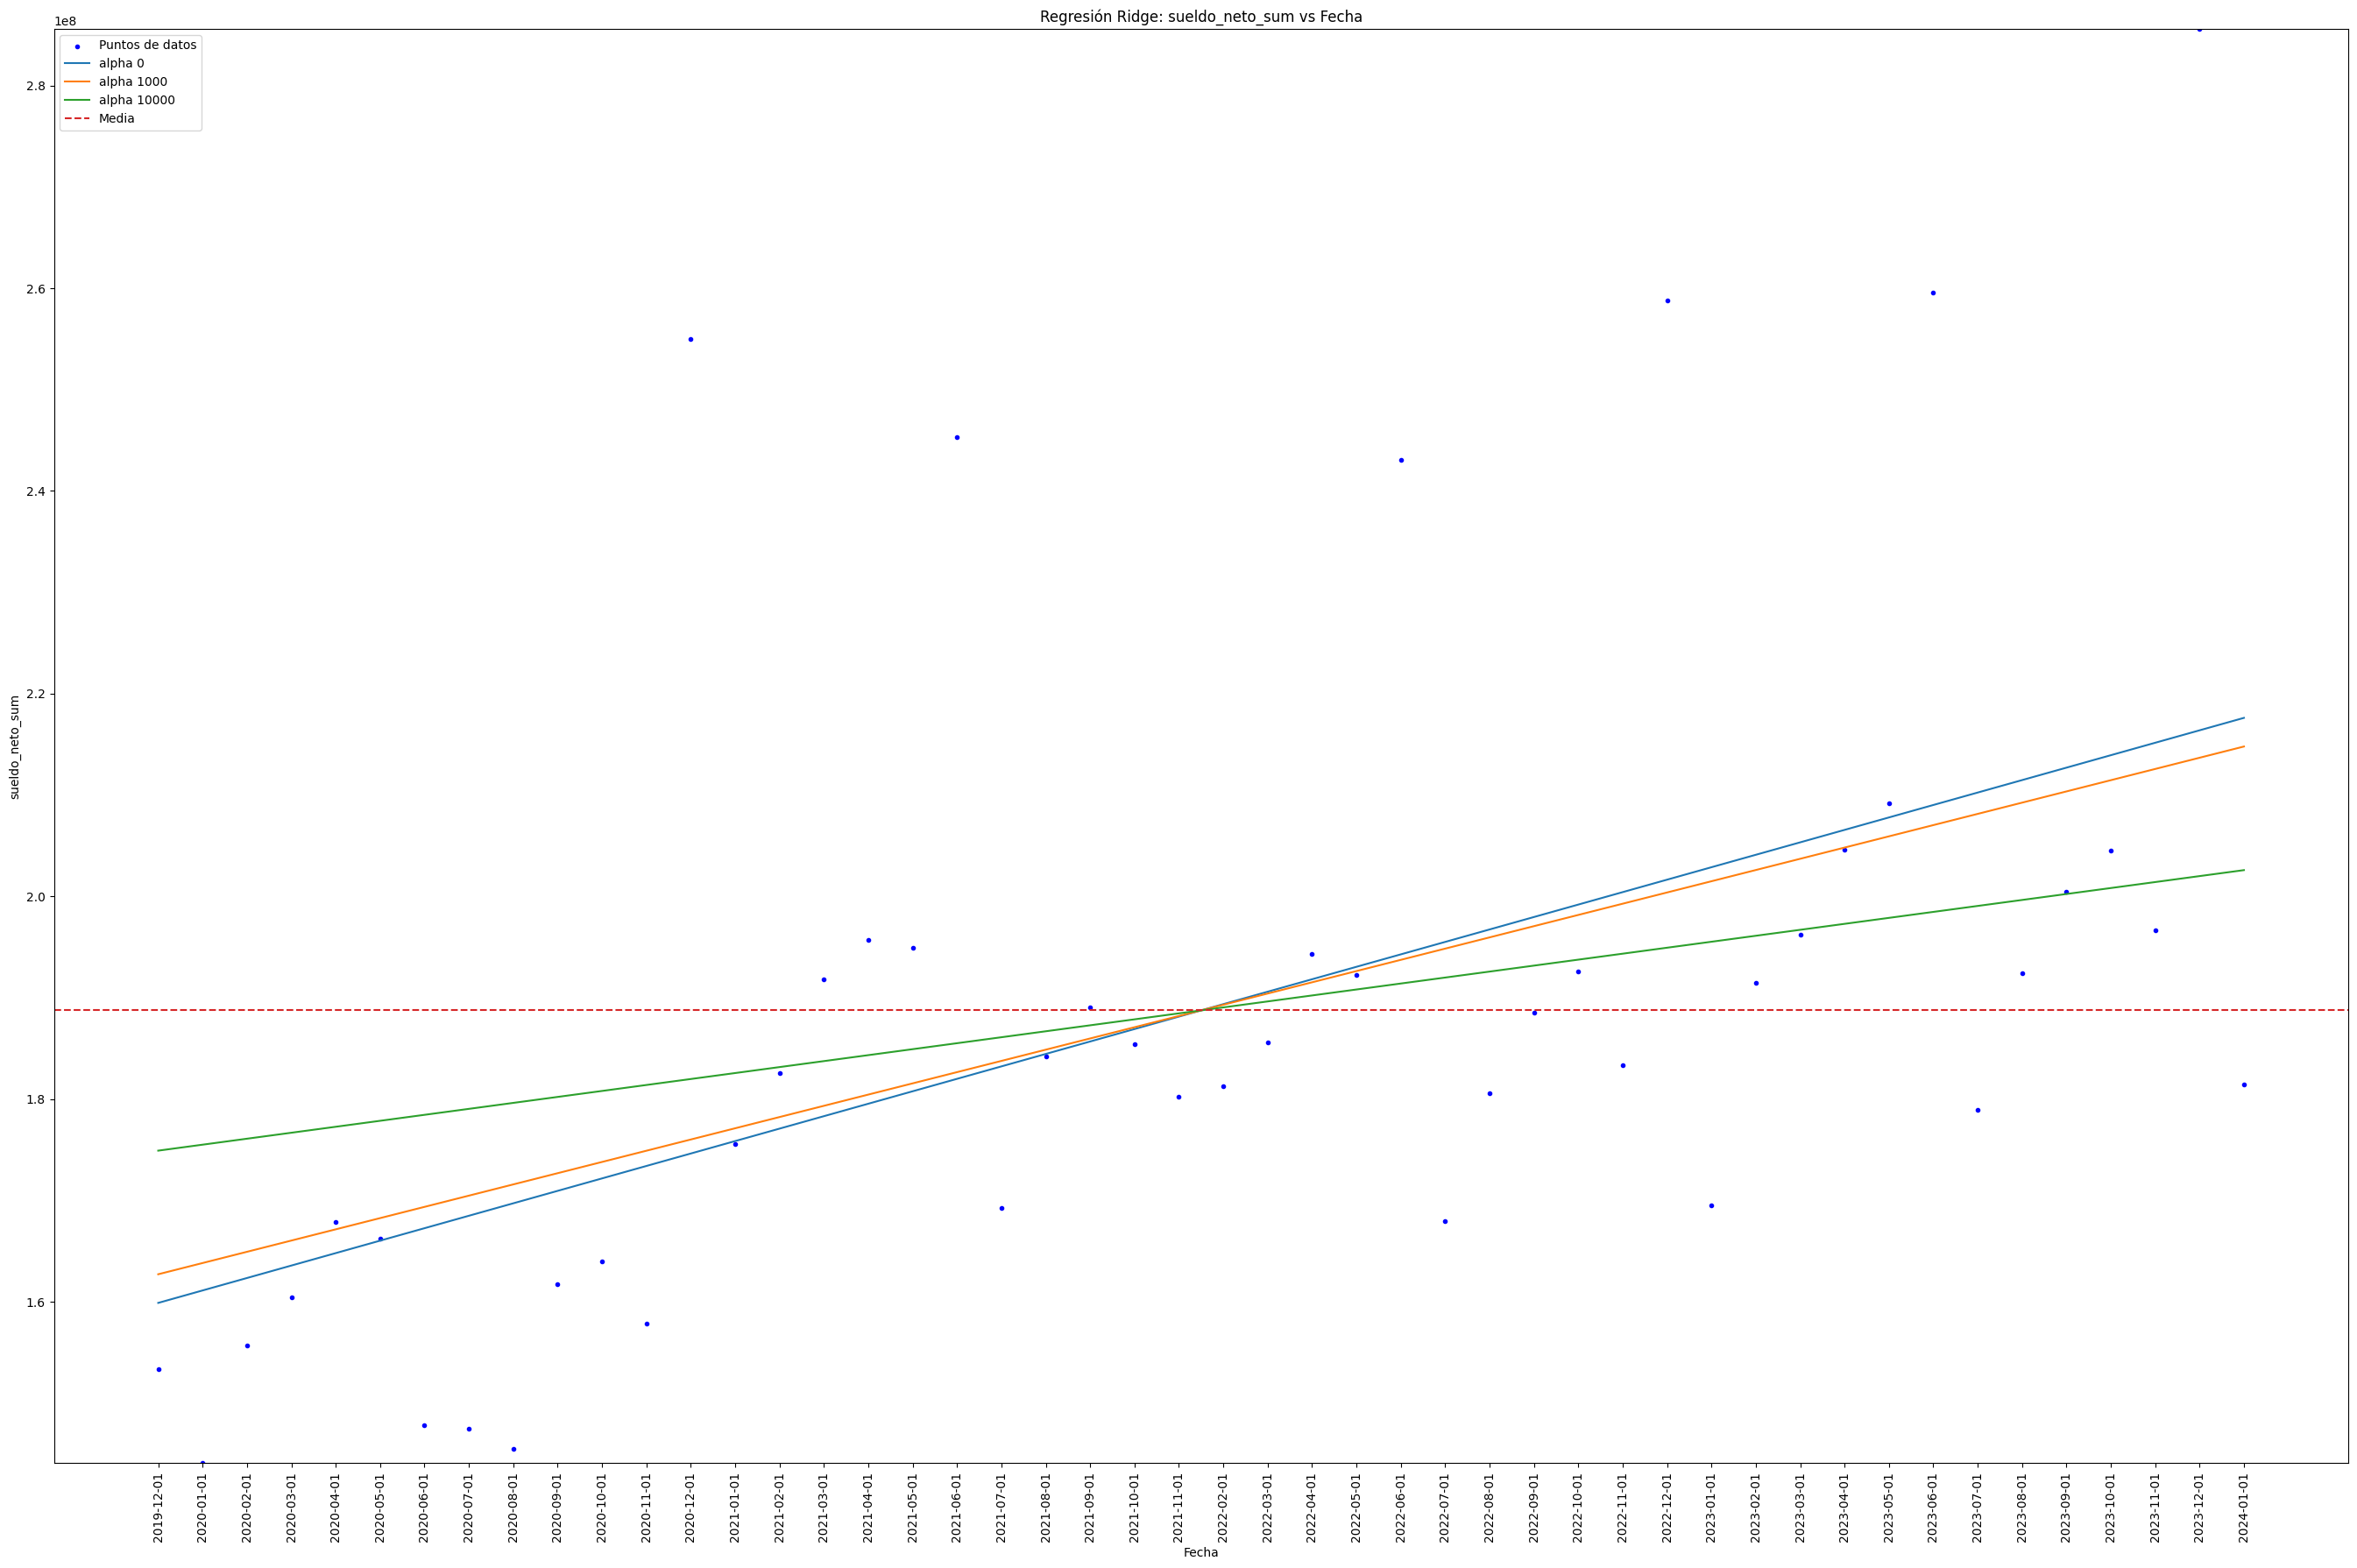

In [21]:
df_by_sal = prepare_data()  # Asumimos que esta función está definida en otra parte del código
linear_regression_ridge_model(df_by_sal, "Fecha", "sueldo_neto_sum", alphas=[0, 1000, 10000])

## Regresión Lasso

In [22]:
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

def linear_regression_lasso_model(df: pd.DataFrame, x: str, y: str, alphas: List[int]) -> None:
    """
    Realiza una regresión Lasso con diferentes valores de alpha y grafica los resultados.

    Args:
    df (pd.DataFrame): El DataFrame de entrada.
    x (str): El nombre de la columna de características.
    y (str): El nombre de la columna objetivo.
    alphas (List[int]): Lista de valores alpha para la regresión Lasso.
    """
    X = transform_variable(df, x).values.reshape(-1, 1)
    y_data = df[y]

    fig, ax = plt.subplots(figsize=(27, 18))
    
    # Graficar puntos de datos
    ax.scatter(df[x], y_data, marker='.', c='blue', label='Puntos de datos')

    # Realizar regresión Lasso para cada alpha
    for i, alpha in enumerate(alphas):
        model = train_model(X, y_data, Lasso, {'alpha': alpha})
        y_pred = model.predict(X)
        ax.plot(df[x], y_pred, color=f"C{i}", label=f"alpha {alpha}")
        print(f"alpha: {alpha}, coeficientes: {model.coef_[0]:.4f}, intercepto: {model.intercept_:.4f}")

    # Graficar la media
    mean = y_data.mean()
    ax.axhline(y=mean, color=f"C{len(alphas)}", label='Media', linestyle='--')

    # Configurar el gráfico
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Regresión Lasso: {y} vs {x}')
    ax.legend(loc="upper left")
    ax.tick_params(axis='x', rotation=90)
    
    # Ajustar los límites del eje y
    ax.set_ylim([y_data.min(), y_data.max()])

    # Guardar el gráfico
    plt.tight_layout()
    plt.savefig(f'../img/regresion/lineal/lr_lasso_{y}_{x}.png')
    plt.show()
    plt.close(fig)

Usando Lasso con parámetros {'alpha': 0}
alpha: 0, coeficientes: 1227923.2997, intercepto: 159905731.3168
Usando Lasso con parámetros {'alpha': 10000000}
alpha: 10000000, coeficientes: 1175817.3510, intercepto: 161130221.1127
Usando Lasso con parámetros {'alpha': 100000000}
alpha: 100000000, coeficientes: 706863.8121, intercepto: 172150629.2760


/Users/armandoalexissepulveda/Documents/Machine_Learning/venv/lib/python3.12/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/armandoalexissepulveda/Documents/Machine_Learning/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/armandoalexissepulveda/Documents/Machine_Learning/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.636e+16, tolerance: 4.662e+12 Linear regression models with null weight for the l1 regularization term 

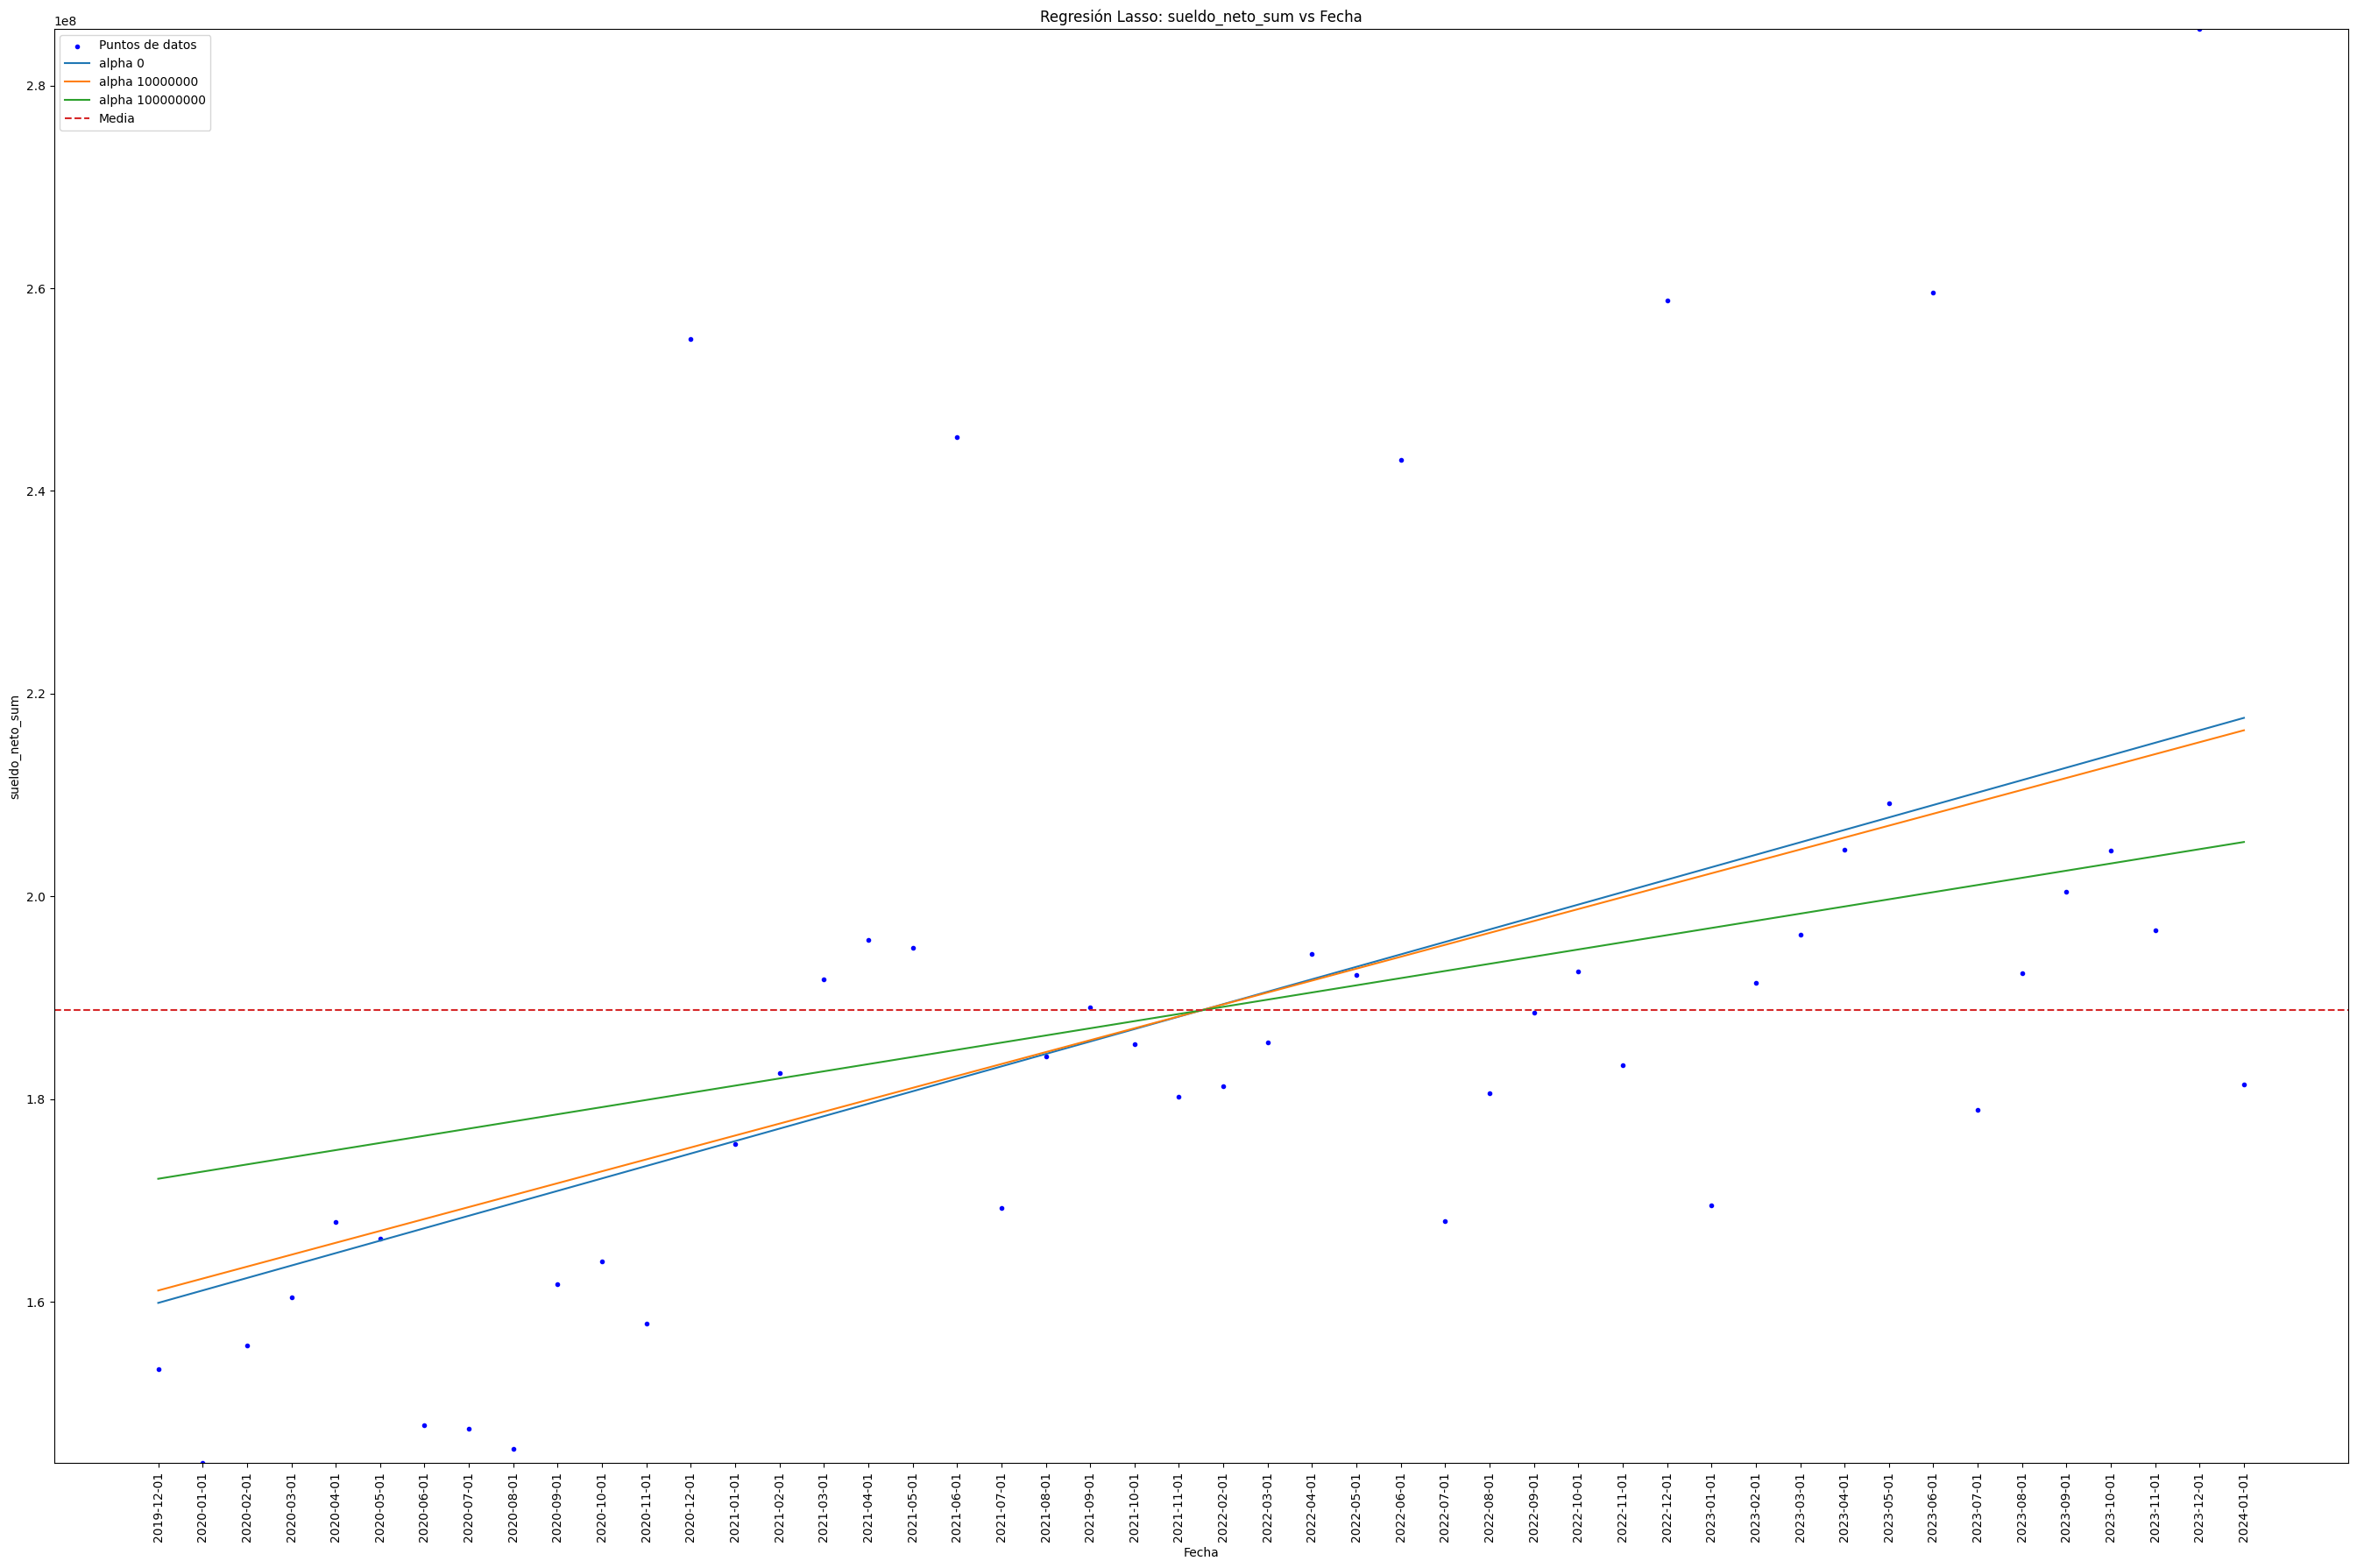

In [23]:
df_by_sal = prepare_data()  # Asumimos que esta función está definida en otra parte del código
linear_regression_lasso_model(df_by_sal, "Fecha", "sueldo_neto_sum", alphas=[0, 10000000, 100000000])

# Polinomial
---

## Regresión con función polinomial

In [24]:
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def polynomial_regression_model(df: pd.DataFrame, x: str, y: str, degrees: List[int]) -> None:
    """
    Realiza una regresión polinomial con diferentes grados y grafica los resultados.

    Args:
    df (pd.DataFrame): El DataFrame de entrada.
    x (str): El nombre de la columna de características.
    y (str): El nombre de la columna objetivo.
    degrees (List[int]): Lista de grados para la regresión polinomial.
    """
    X = transform_variable(df, x).values.reshape(-1, 1)
    y_data = df[y]

    fig, ax = plt.subplots(figsize=(27, 18))
    
    # Graficar puntos de datos
    ax.scatter(df[x], y_data, marker='.', c='blue', label='Puntos de datos')

    # Realizar regresión polinomial para cada grado
    for i, degree in enumerate(degrees):
        poly_features = PolynomialFeatures(degree=degree)
        X_poly = poly_features.fit_transform(X)
        
        model = train_model(X_poly, y_data, LinearRegression)
        y_pred = model.predict(X_poly)
        
        ax.plot(df[x], y_pred, color=f"C{i}", label=f"Grado {degree}")
        
        print(f"Grado: {degree}")
        print(f"Coeficientes: {model.coef_}")
        print(f"Intercepto: {model.intercept_:.4f}")
        print("--------------------")

    # Configurar el gráfico
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Regresión Polinomial: {y} vs {x}')
    ax.legend(loc="upper left")
    ax.tick_params(axis='x', rotation=90)
    
    # Ajustar los límites del eje y
    ax.set_ylim([y_data.min(), y_data.max()])

    # Guardar el gráfico
    plt.tight_layout()
    plt.savefig(f'../img/regresion/polinomeal/pr_{y}_{x}.png')
    plt.show()
    plt.close(fig)

Usando LinearRegression con parámetros por defecto
Grado: 1
Coeficientes: [      0.        1227923.2997183]
Intercepto: 159905731.3168
--------------------
Usando LinearRegression con parámetros por defecto
Grado: 2
Coeficientes: [      0.         2322371.46302986  -23286.13113429]
Intercepto: 151514962.0648
--------------------
Usando LinearRegression con parámetros por defecto
Grado: 5
Coeficientes: [ 0.00000000e+00 -3.56178430e+06  1.07729880e+06 -6.63919943e+04
  1.58981342e+03 -1.31671959e+01]
Intercepto: 154338030.0555
--------------------
Usando LinearRegression con parámetros por defecto
Grado: 8
Coeficientes: [ 0.00000000e+00  2.15859610e+07 -9.70213384e+06  1.70702220e+06
 -1.42442287e+05  6.36195421e+03 -1.56727471e+02  2.01038158e+00
 -1.04934535e-02]
Intercepto: 144978407.3863
--------------------


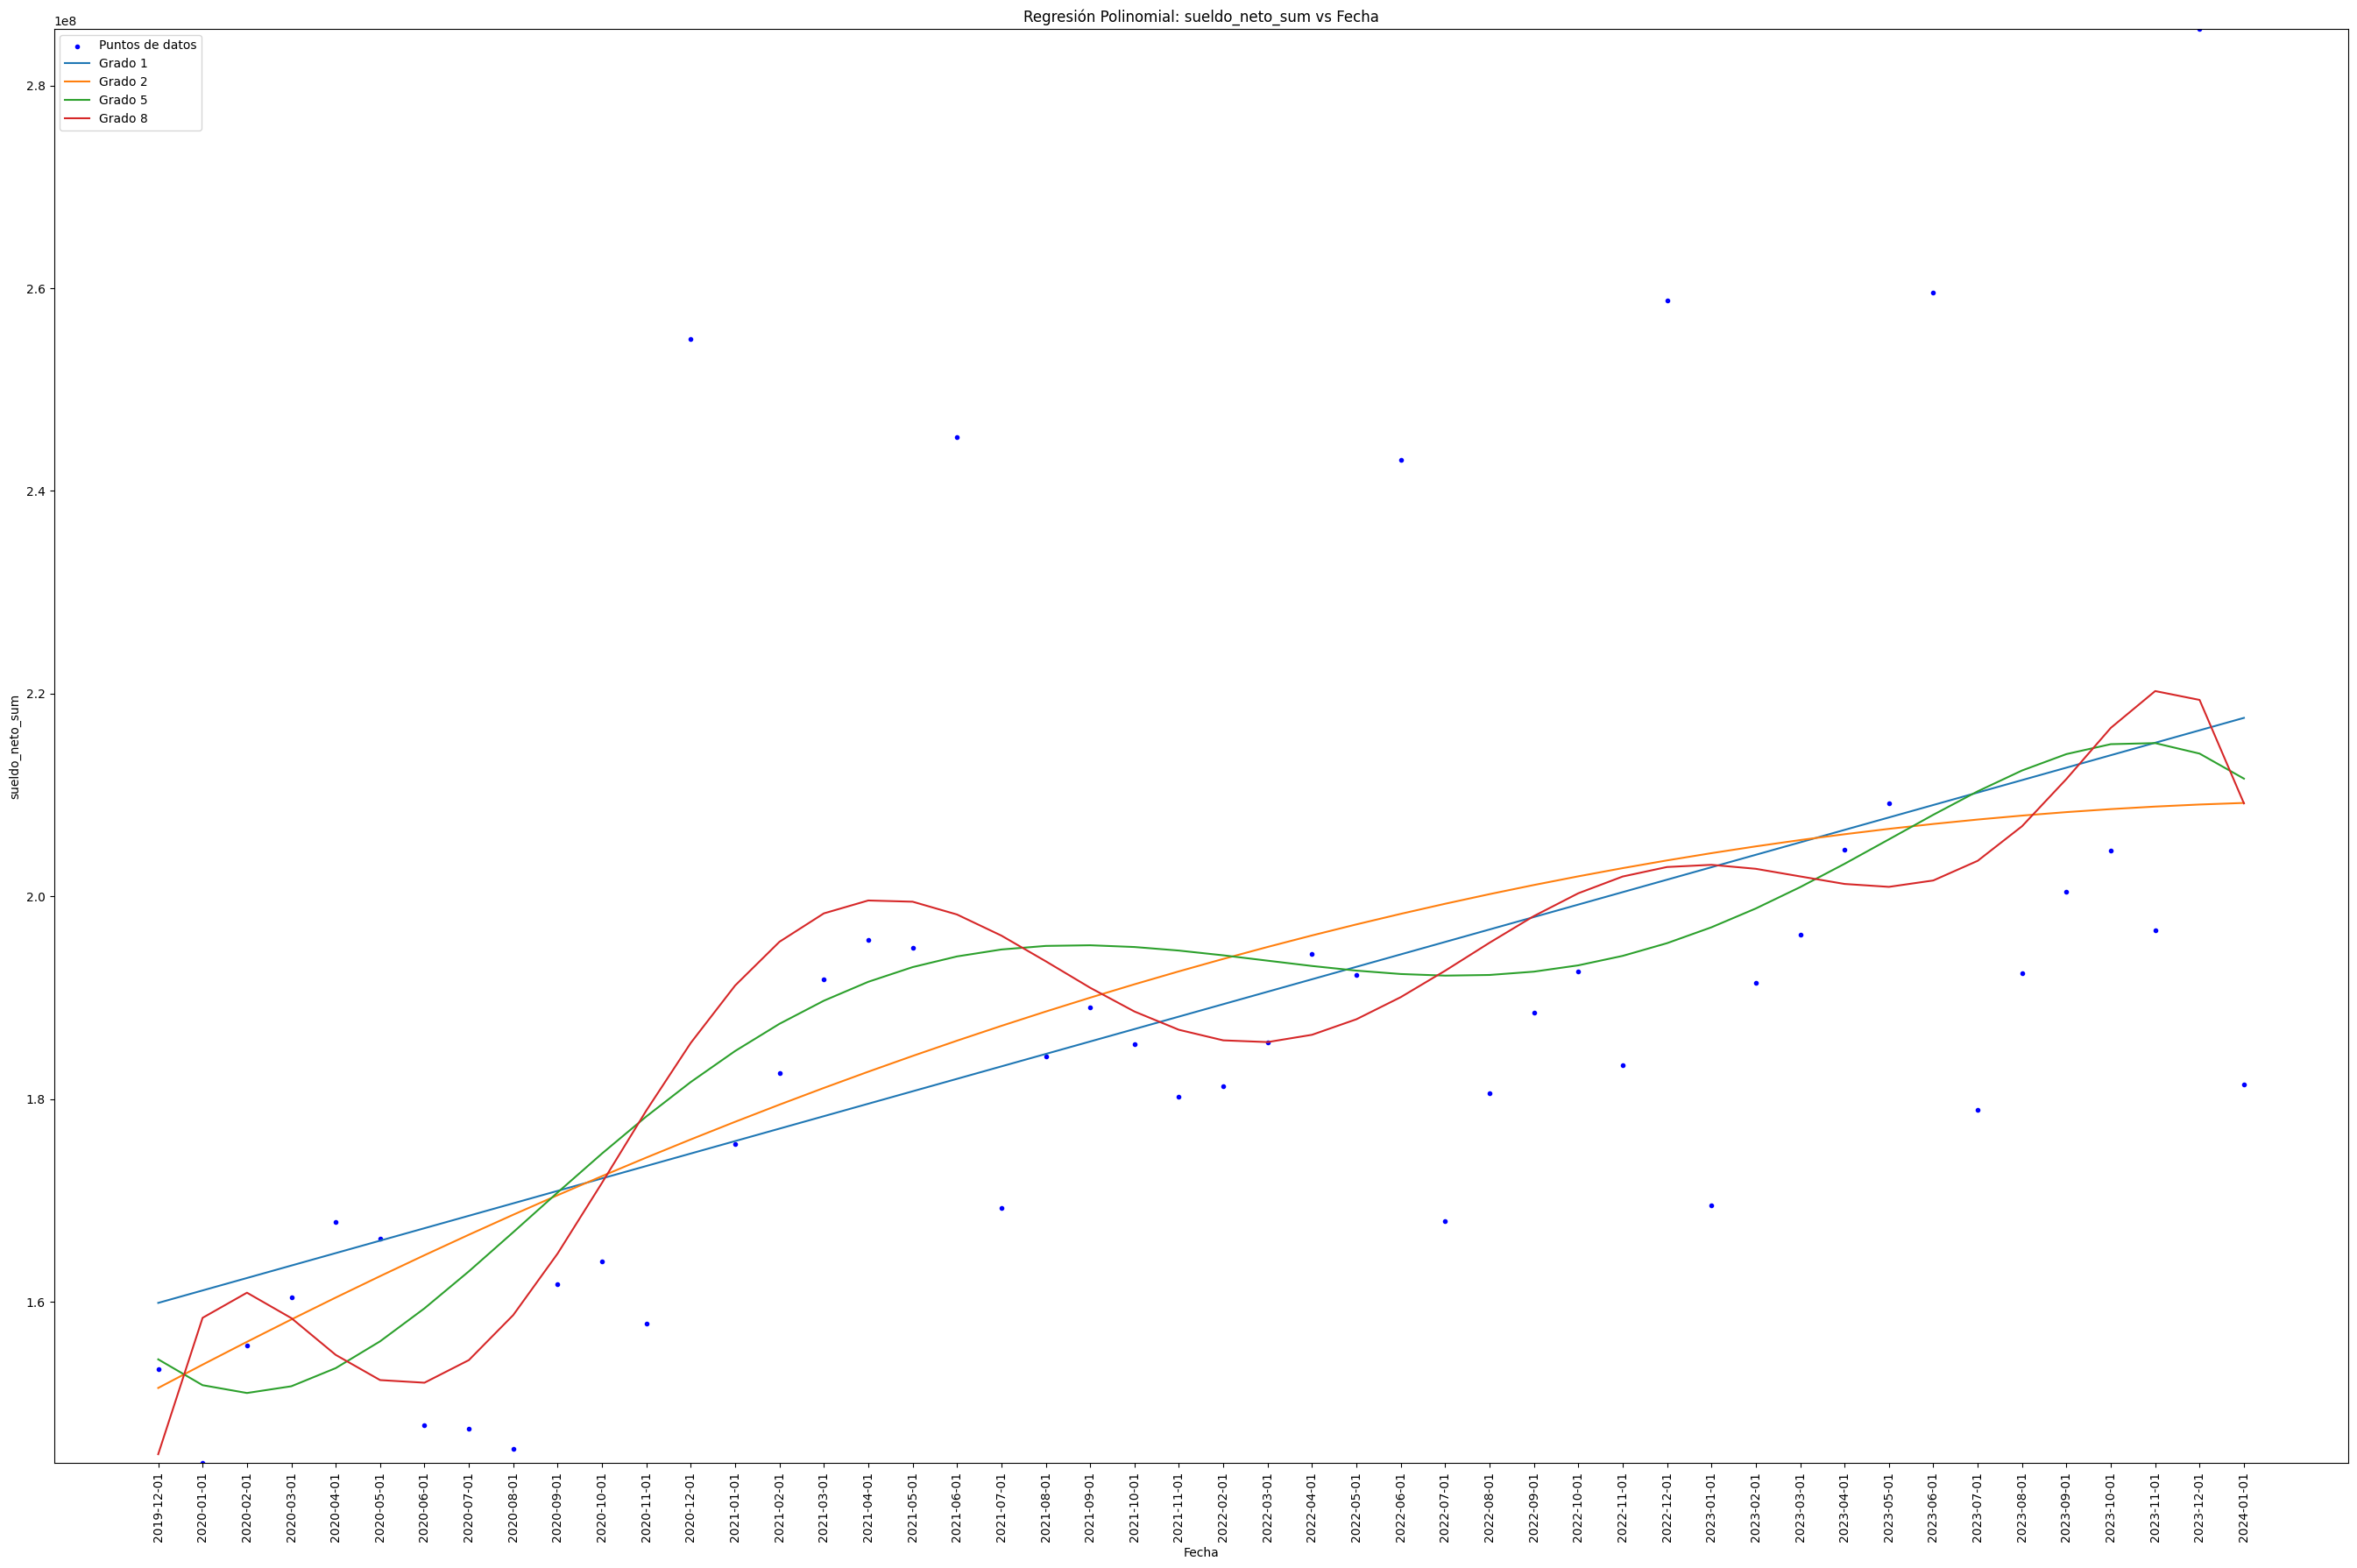

In [25]:
df_by_sal = prepare_data()  # Asumimos que esta función está definida en otra parte del código
polynomial_regression_model(df_by_sal, "Fecha", "sueldo_neto_sum", degrees=[1, 2, 5, 8])

## Regresión polinomial con ridge

In [26]:
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

def polynomial_ridge_regression_model(df: pd.DataFrame, x: str, y: str, degrees: List[int], alphas: List[float]) -> None:
    """
    Realiza una regresión polinomial Ridge con diferentes grados y valores de alpha, y grafica los resultados.

    Args:
    df (pd.DataFrame): El DataFrame de entrada.
    x (str): El nombre de la columna de características.
    y (str): El nombre de la columna objetivo.
    degrees (List[int]): Lista de grados para la regresión polinomial.
    alphas (List[float]): Lista de valores alpha para la regularización Ridge.
    """
    X = transform_variable(df, x).values.reshape(-1, 1)
    y_data = df[y]

    fig, ax = plt.subplots(figsize=(27, 18))
    
    # Graficar puntos de datos
    ax.scatter(df[x], y_data, marker='.', c='blue', label='Puntos de datos')

    # Realizar regresión polinomial Ridge para cada grado y alpha
    for i, degree in enumerate(degrees):
        poly_features = PolynomialFeatures(degree=degree)
        X_poly = poly_features.fit_transform(X)
        
        for j, alpha in enumerate(alphas):
            model = train_model(X_poly, y_data, Ridge, {'alpha': alpha})
            y_pred = model.predict(X_poly)
            
            color_index = i * len(alphas) + j
            ax.plot(df[x], y_pred, color=f"C{color_index}", label=f"Grado {degree}, Alpha {alpha}")
            
            print(f"Grado: {degree}, Alpha: {alpha}")
            print(f"Coeficientes: {model.coef_}")
            print(f"Intercepto: {model.intercept_:.4f}")
            print("--------------------")

    # Configurar el gráfico
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Regresión Polinomial Ridge: {y} vs {x}')
    ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)
    ax.tick_params(axis='x', rotation=90)
    
    # Ajustar los límites del eje y
    ax.set_ylim([y_data.min(), y_data.max()])

    # Guardar el gráfico
    plt.tight_layout()
    plt.savefig(f'../img/regresion/polinomeal/pr_ridge_{y}_{x}.png', bbox_inches='tight')
    plt.show()
    plt.close(fig)

Usando Ridge con parámetros {'alpha': 0}
Grado: 8, Alpha: 0
Coeficientes: [ 0.00000000e+00  2.15859610e+07 -9.70213384e+06  1.70702220e+06
 -1.42442287e+05  6.36195421e+03 -1.56727471e+02  2.01038158e+00
 -1.04934516e-02]
Intercepto: 144973031.4480
--------------------
Usando Ridge con parámetros {'alpha': 100}
Grado: 8, Alpha: 100
Coeficientes: [ 0.00000000e+00 -2.17082712e+05 -1.31130762e+06  4.22848130e+05
 -4.31408119e+04  2.11114865e+03 -5.45564803e+01  7.19167314e-01
 -3.81644402e-03]
Intercepto: 154648198.6864
--------------------
Usando Ridge con parámetros {'alpha': 1000}
Grado: 8, Alpha: 1000
Coeficientes: [ 0.00000000e+00 -5.89520864e+04 -2.26887920e+05  1.69667542e+05
 -1.94629282e+04  9.78886073e+02 -2.52784993e+01  3.29393124e-01
 -1.72066989e-03]
Intercepto: 149628862.2598
--------------------


/Users/armandoalexissepulveda/Documents/Machine_Learning/venv/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.61509e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/armandoalexissepulveda/Documents/Machine_Learning/venv/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.96398e-25): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


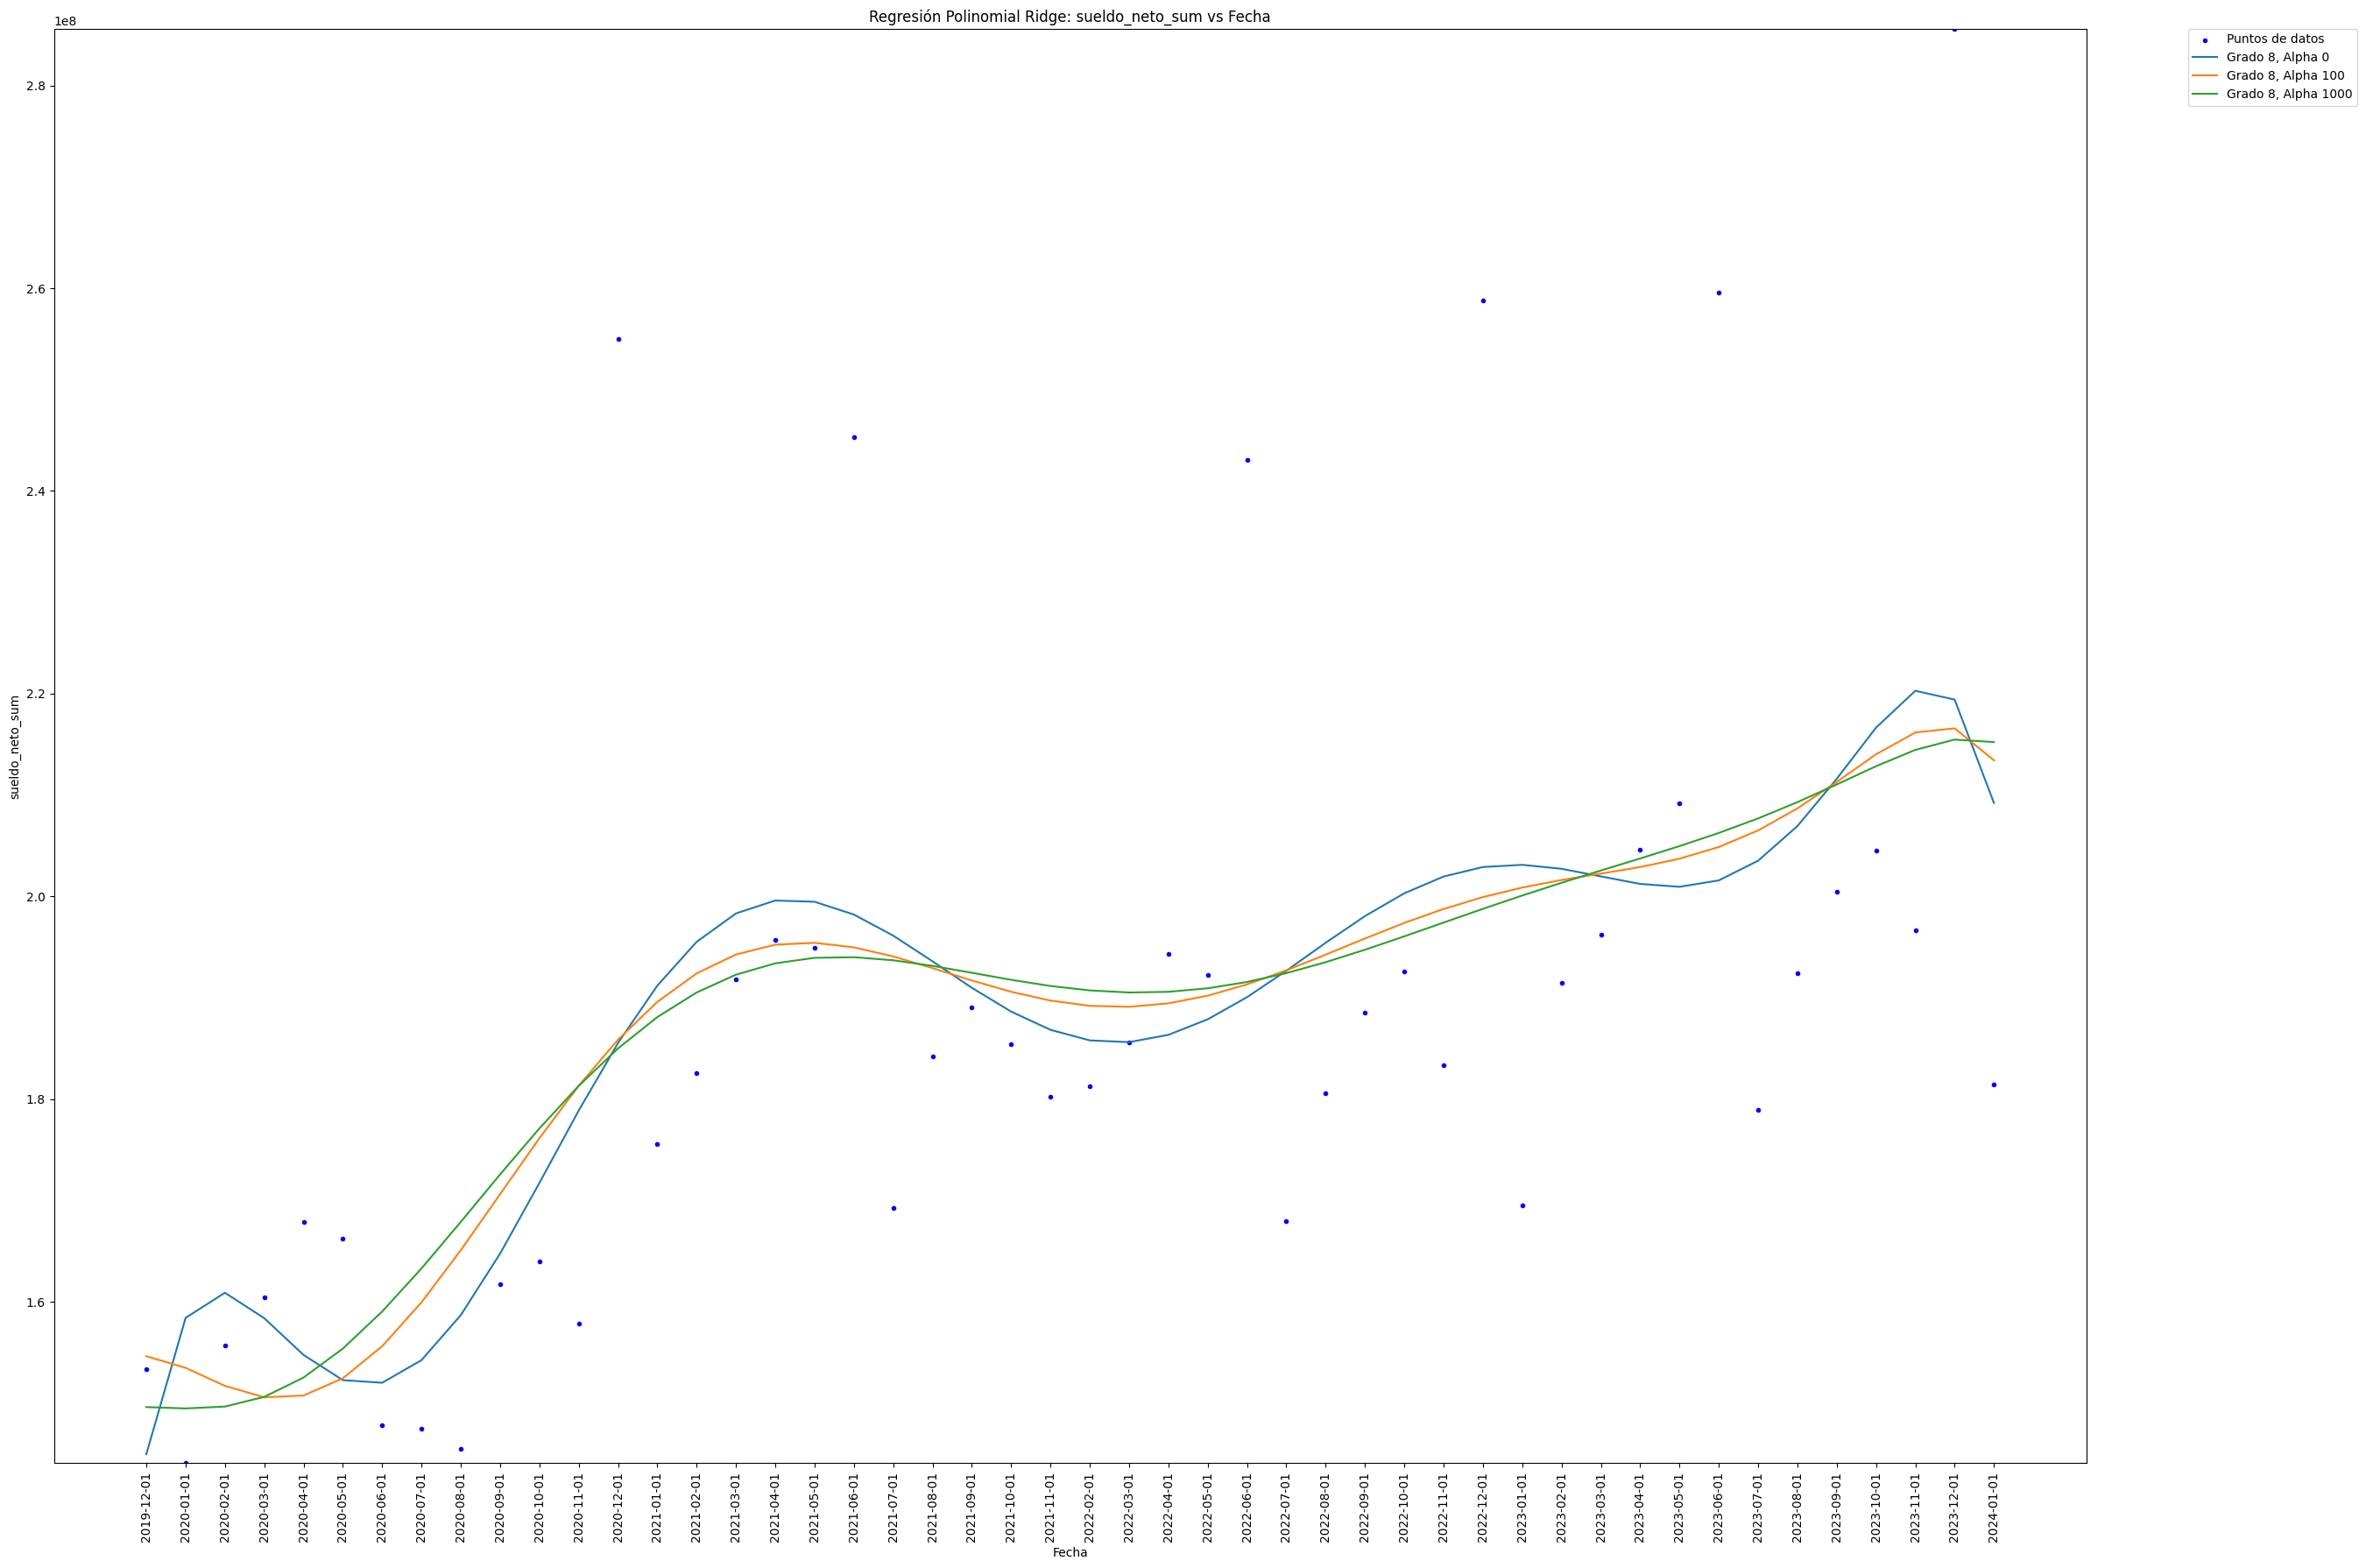

In [27]:
df_by_sal = prepare_data()  # Asumimos que esta función está definida en otra parte del código
polynomial_ridge_regression_model(df_by_sal, "Fecha", "sueldo_neto_sum", degrees=[8], alphas=[0, 100, 1000])

## Regresión polinomial con Lasso

In [30]:
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso

def polynomial_lasso_regression_model(df: pd.DataFrame, x: str, y: str, degrees: List[int], alphas: List[float]) -> None:
    """
    Realiza una regresión polinomial con regularización Lasso para diferentes grados y valores alpha.
    
    :param df: DataFrame con los datos
    :param x: Nombre de la columna para la variable independiente
    :param y: Nombre de la columna para la variable dependiente
    :param degrees: Lista de grados polinomiales a probar
    :param alphas: Lista de valores alpha para la regularización Lasso
    """
    fixed_x = transform_variable(df, x)
    fig, ax = create_plot()
    plot_points(ax, fixed_x, df[y], scatter_params={'marker': '.', 'c': 'blue'})

    for degree_index, degree in enumerate(degrees):
        for alpha_index, alpha in enumerate(alphas):
            polynomial_transformer = PolynomialFeatures(degree=degree)
            X_transformed = polynomial_transformer.fit_transform(fixed_x)
            trained_model = train_model(X_transformed, df[y], Lasso, {'alpha': alpha})  # type: Lasso
            
            color_number = degree_index * len(alphas) + alpha_index
            plot_line(ax, df[x], trained_model.predict(X_transformed), 
                      color=f"C{color_number}", 
                      label=f"Grado {degree}, Alpha {alpha}")
            
            print(f"Coeficientes: {trained_model.coef_}, Intercepto: {trained_model.intercept_}", flush=True)

    ax.legend(loc="upper left")

    finalize_plot(fig, ax, f'../img/regresion/polinomeal/pr_lasso_{y}_{x}.png', ylim=[min(df[y]), max(df[y])])


Usando Lasso con parámetros {'alpha': 0}
Coeficientes: [ 0.00000000e+00  4.57655625e+06 -1.10954825e+05 -3.19232880e+02
  1.91395588e+01  3.71667808e-01  3.07317282e-03 -3.55083101e-05
 -2.36161723e-06], Intercepto: 142281110.91845
Usando Lasso con parámetros {'alpha': 100000000}
Coeficientes: [ 0.00000000e+00  0.00000000e+00  1.21664738e+05 -2.65380005e+03
 -2.05344980e+01  3.82327384e-01  7.49075280e-03  5.18070091e-05
 -1.25530975e-06], Intercepto: 161938096.35661486
Usando Lasso con parámetros {'alpha': 1000000000}
Coeficientes: [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.81333224e+03
 -8.79395693e+01 -3.88976138e-01  4.90628094e-03  1.41684170e-04
  2.11056322e-06], Intercepto: 168233026.43962485


/Users/armandoalexissepulveda/Documents/Machine_Learning/venv/lib/python3.12/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/armandoalexissepulveda/Documents/Machine_Learning/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/armandoalexissepulveda/Documents/Machine_Learning/venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.553e+16, tolerance: 4.662e+12 Linear regression models with null weight for the l1 regularization term 

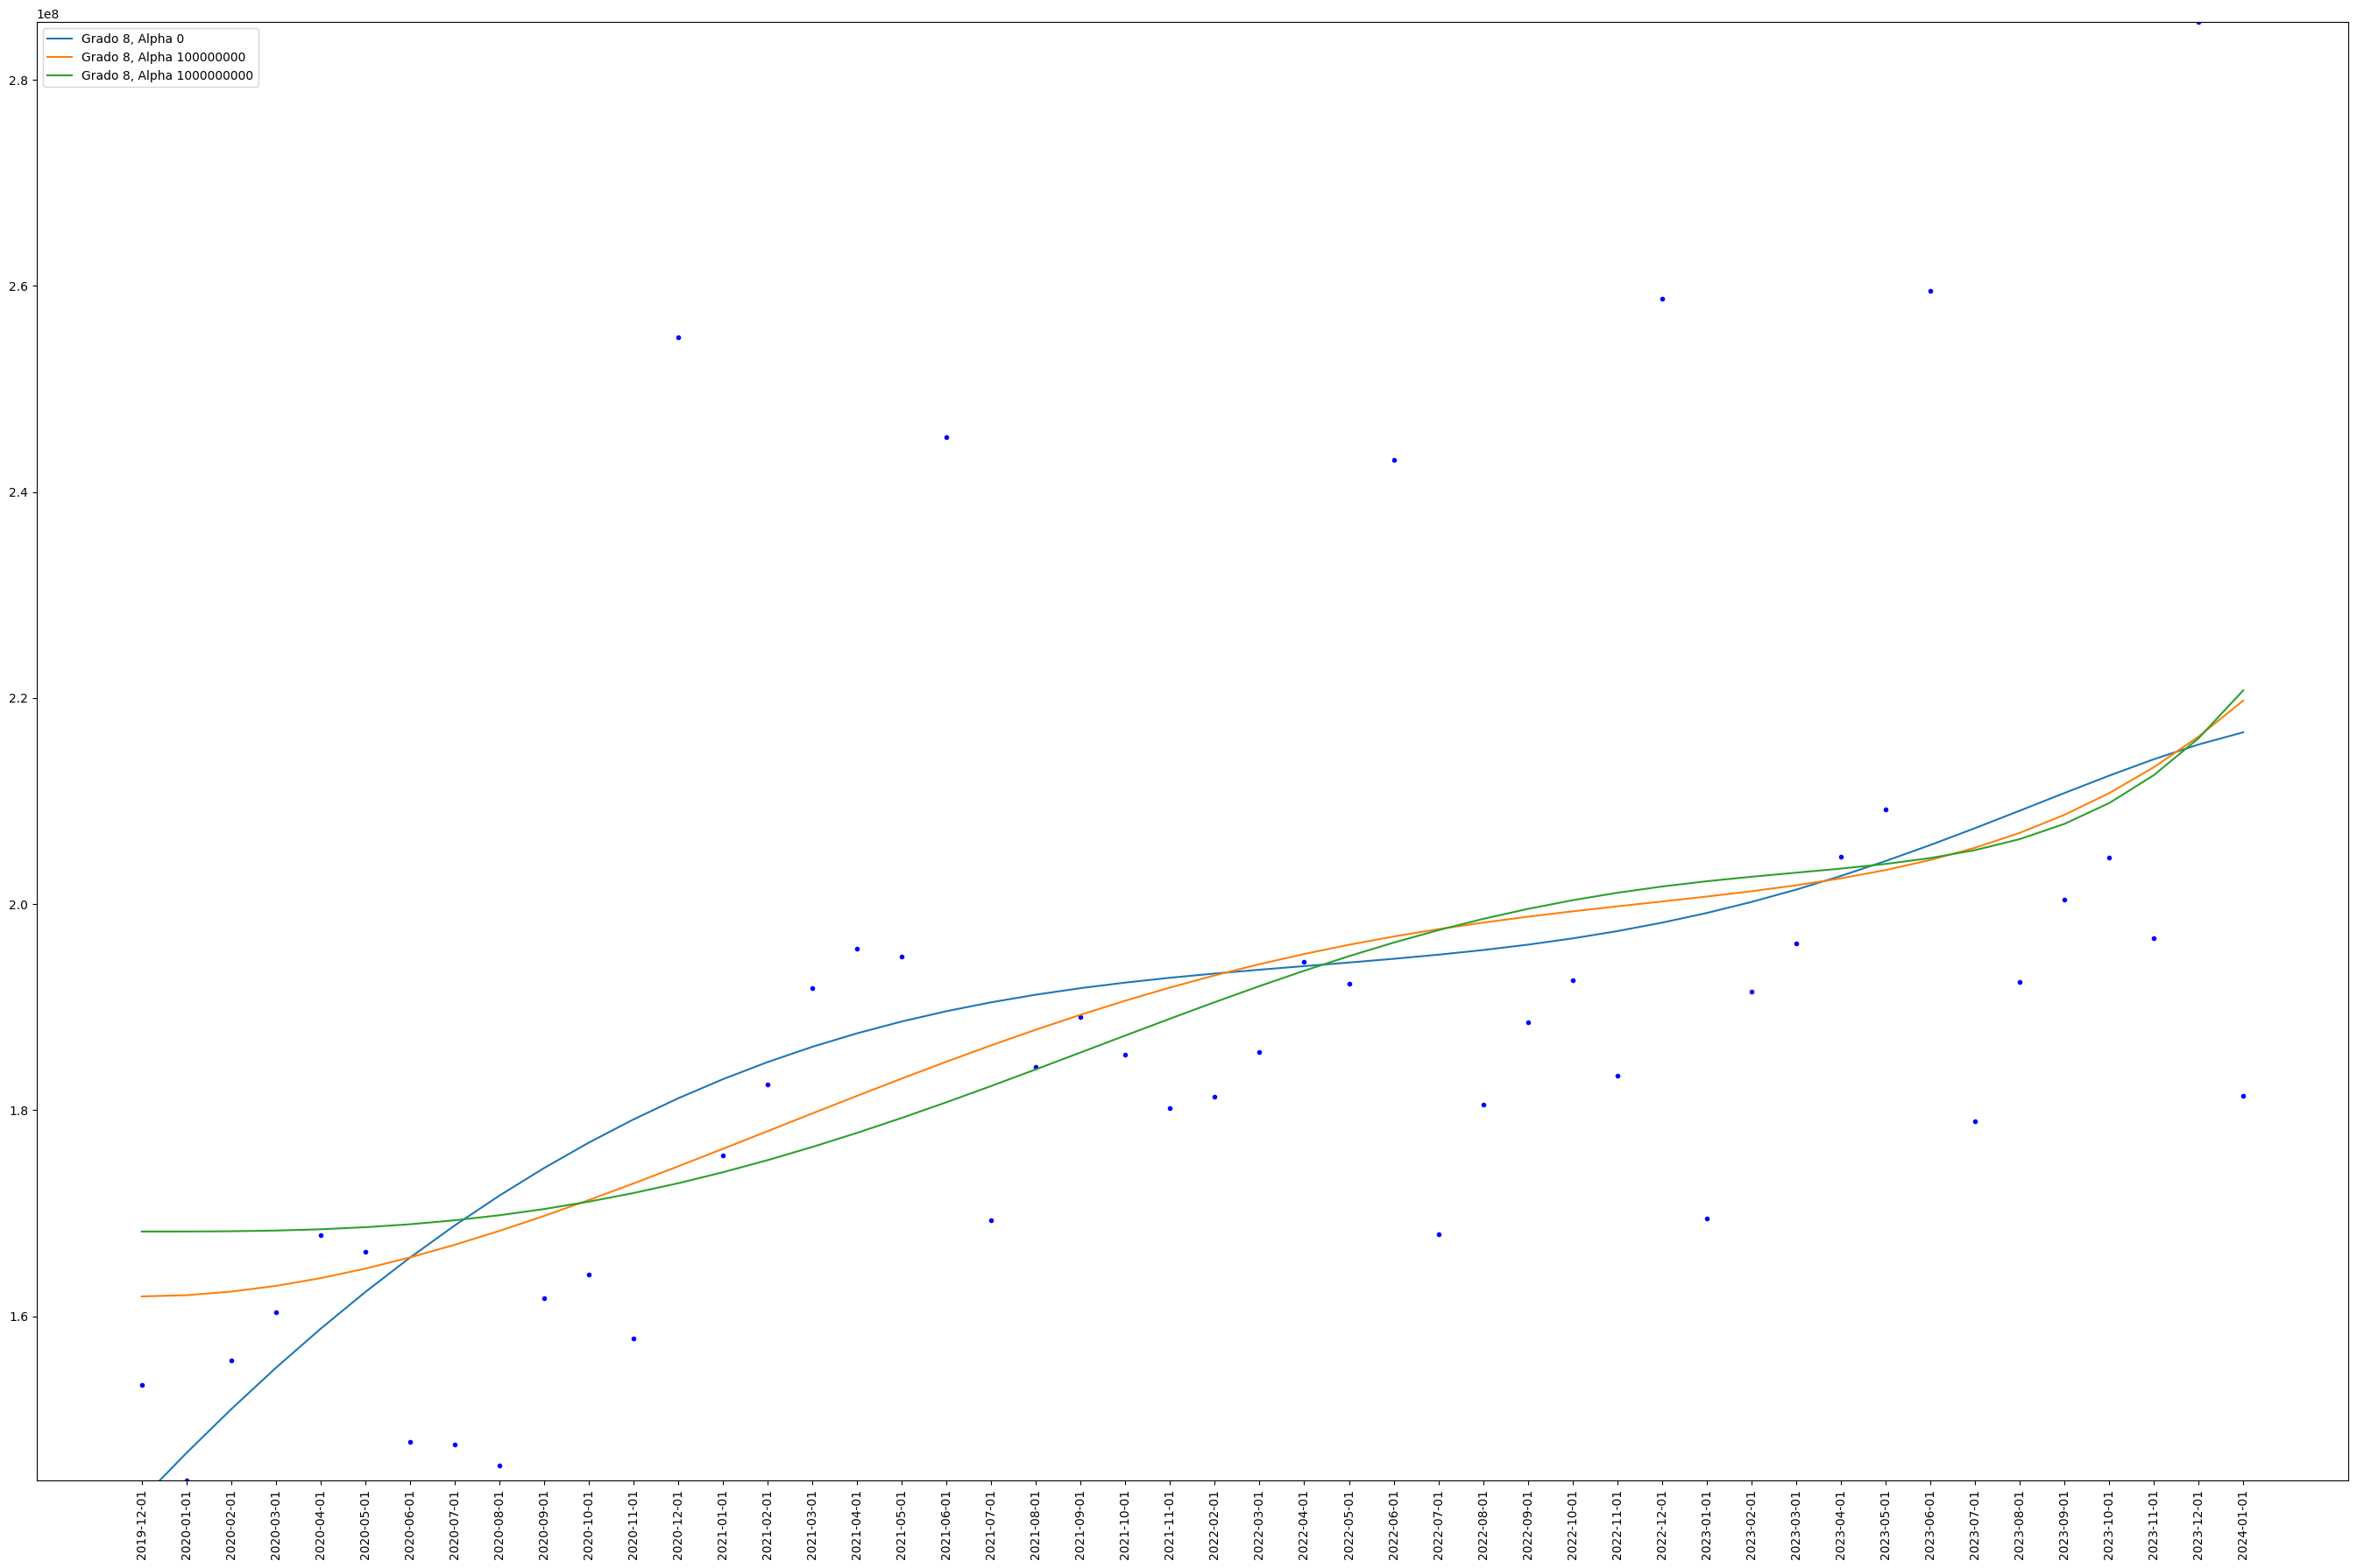

In [31]:
# Preparación y ejecución del modelo

df_by_sal = prepare_data()
polynomial_lasso_regression_model(df_by_sal, "Fecha", "sueldo_neto_sum",degrees=[8], alphas=[0,100000000,1000000000])


# Predicción
---

## Regresión líneal predictiva

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

def linear_regression_model_predict(df: pd.DataFrame, x: str, y: str) -> None:
    """
    Realiza una regresión lineal, evalúa el modelo en conjuntos de entrenamiento y prueba,
    y visualiza los resultados.

    Args:
    df (pd.DataFrame): El DataFrame de entrada.
    x (str): El nombre de la columna de características.
    y (str): El nombre de la columna objetivo.
    """
    print("Usando el modelo de regresión lineal de sklearn para predicción")

    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = split_train_test(df, x, y, test_size=0.3, random_state=0)

    # Entrenar el modelo con los datos de entrenamiento
    model = train_model(X_train, y_train, LinearRegression)
    coef, intercept = model.coef_[0], model.intercept_

    print(f"Coeficiente: {coef:.4f}, Intercepto: {intercept:.4f}")
    print(f"R-cuadrado (entrenamiento): {model.score(X_train, y_train):.4f}")
    print(f"R-cuadrado (prueba): {model.score(X_test, y_test):.4f}")

    # Entrenar un modelo con todos los datos
    total_model = train_model(X_test, y_test, LinearRegression, {})
    total_coef, total_intercept = total_model.coef_[0], total_model.intercept_

    print('R-squared score total model (training): {:.9f}'.format(total_model.score(X_train, y_train)))
    print('R-squared score total model (test): {:.9f}'.format(total_model.score(X_test, y_test)))

    # Crear el gráfico
    fig, ax = plt.subplots(figsize=(27, 18))

    # Graficar puntos de datos
    ax.scatter(X_train, y_train, marker='.', c='blue', label='Entrenamiento')
    ax.scatter(X_test, y_test, marker='x', c='orange', label='Prueba')

    # Graficar líneas de regresión
    x_range = range(len(df))
    ax.plot(df[x], [coef * x + intercept for x in x_range], color='blue', label='Regresión entrenada')
    ax.plot(df[x], [total_coef * x + total_intercept for x in x_range], color='green', label='Mejor regresión')

    # Configurar el gráfico
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Regresión Lineal: {y} vs {x}')
    ax.legend(loc="upper left")

    finalize_plot(fig, ax, f'../img/regresion/lineal/lr_model_{y}_{x}.png', ylim=[min(df[y]), max(df[y])])

Usando el modelo de regresión lineal de sklearn para predicción
Usando LinearRegression con parámetros por defecto
Coeficiente: 1163537.9659, Intercepto: 162976691.3064
R-cuadrado (entrenamiento): 0.2821
R-cuadrado (prueba): 0.3229
Usando LinearRegression con parámetros por defecto
R-squared score total model (training): 0.211012707
R-squared score total model (test): 0.369605510


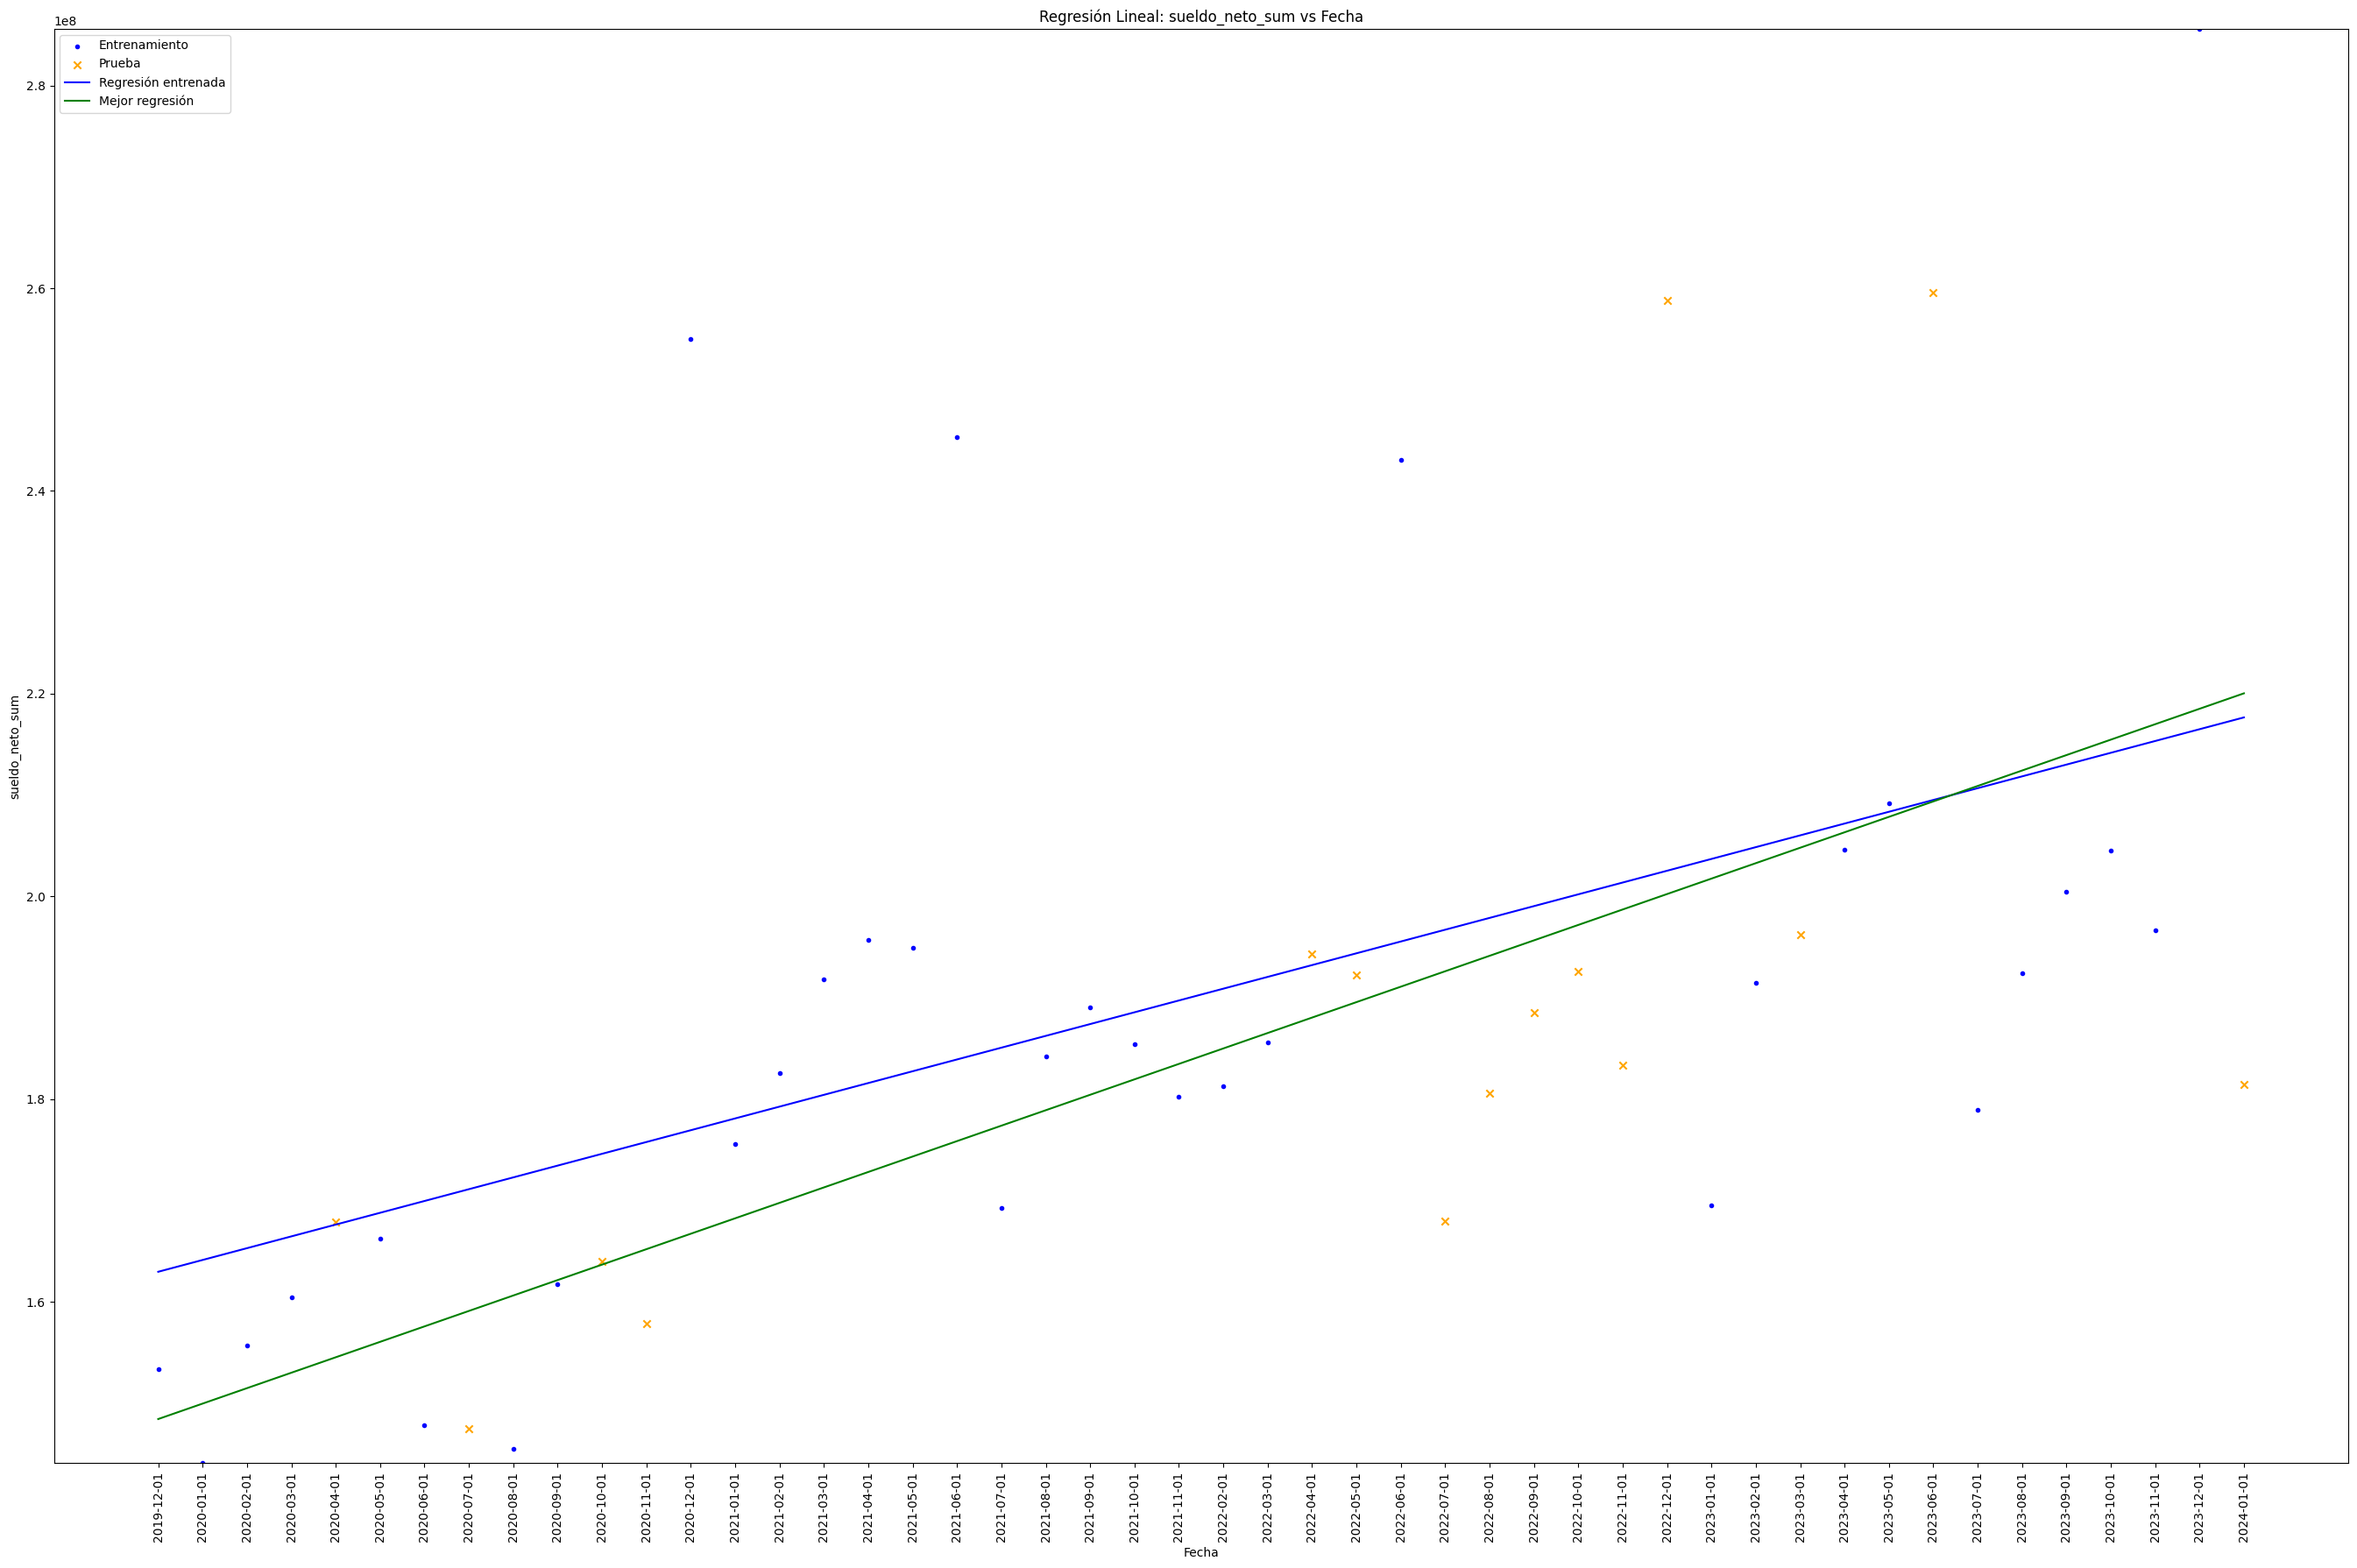

In [33]:
# Preparación y ejecución del modelo

df_by_sal = prepare_data()
linear_regression_model_predict(df_by_sal, "Fecha", "sueldo_neto_sum")

# K Nearest Neighbor
---

## Regresión KNN

In [34]:
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor

def KNN_regression_model(df: pd.DataFrame, x: str, y: str, neighbors: List[int]) -> None:
    """
    Realiza una regresión KNN con diferentes números de vecinos y grafica los resultados.

    Args:
    df (pd.DataFrame): El DataFrame de entrada.
    x (str): El nombre de la columna de características.
    y (str): El nombre de la columna objetivo.
    neighbors (List[int]): Lista de números de vecinos a utilizar en el modelo KNN.
    """
    print("Usando regresión KNN de sklearn")

    X = transform_variable(df, x).values.reshape(-1, 1)
    y_data = df[y]

    fig, ax = plt.subplots(figsize=(27, 18))
    
    # Graficar puntos de datos
    ax.scatter(df[x], y_data, marker='.', c='blue', label='Puntos de datos')

    # Realizar regresión KNN para cada número de vecinos
    for i, n_neighbors in enumerate(neighbors):
        model = train_model(X, y_data, KNeighborsRegressor, {'n_neighbors': n_neighbors})
        y_pred = model.predict(X)
        
        ax.plot(df[x], y_pred, color=f"C{i+1}", label=f"k={n_neighbors}")
        
        print(f"Número de vecinos: {n_neighbors}")
        print(f"R-cuadrado: {model.score(X, y_data):.4f}")
        print("--------------------")

    # Configurar el gráfico
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Regresión KNN: {y} vs {x}')
    ax.legend(loc="upper left")
    ax.tick_params(axis='x', rotation=90)
    
    # Ajustar los límites del eje y
    ax.set_ylim([y_data.min(), y_data.max()])

    # Guardar el gráfico
    plt.tight_layout()
    plt.savefig(f'../img/regresion/knn/KNN_regression_{y}_{x}.png')
    plt.show()
    plt.close(fig)

Usando regresión KNN de sklearn
Usando KNeighborsRegressor con parámetros {'n_neighbors': 1}
Número de vecinos: 1
R-cuadrado: 1.0000
--------------------
Usando KNeighborsRegressor con parámetros {'n_neighbors': 3}
Número de vecinos: 3
R-cuadrado: 0.4251
--------------------
Usando KNeighborsRegressor con parámetros {'n_neighbors': 5}
Número de vecinos: 5
R-cuadrado: 0.3933
--------------------
Usando KNeighborsRegressor con parámetros {'n_neighbors': 10}
Número de vecinos: 10
R-cuadrado: 0.3183
--------------------


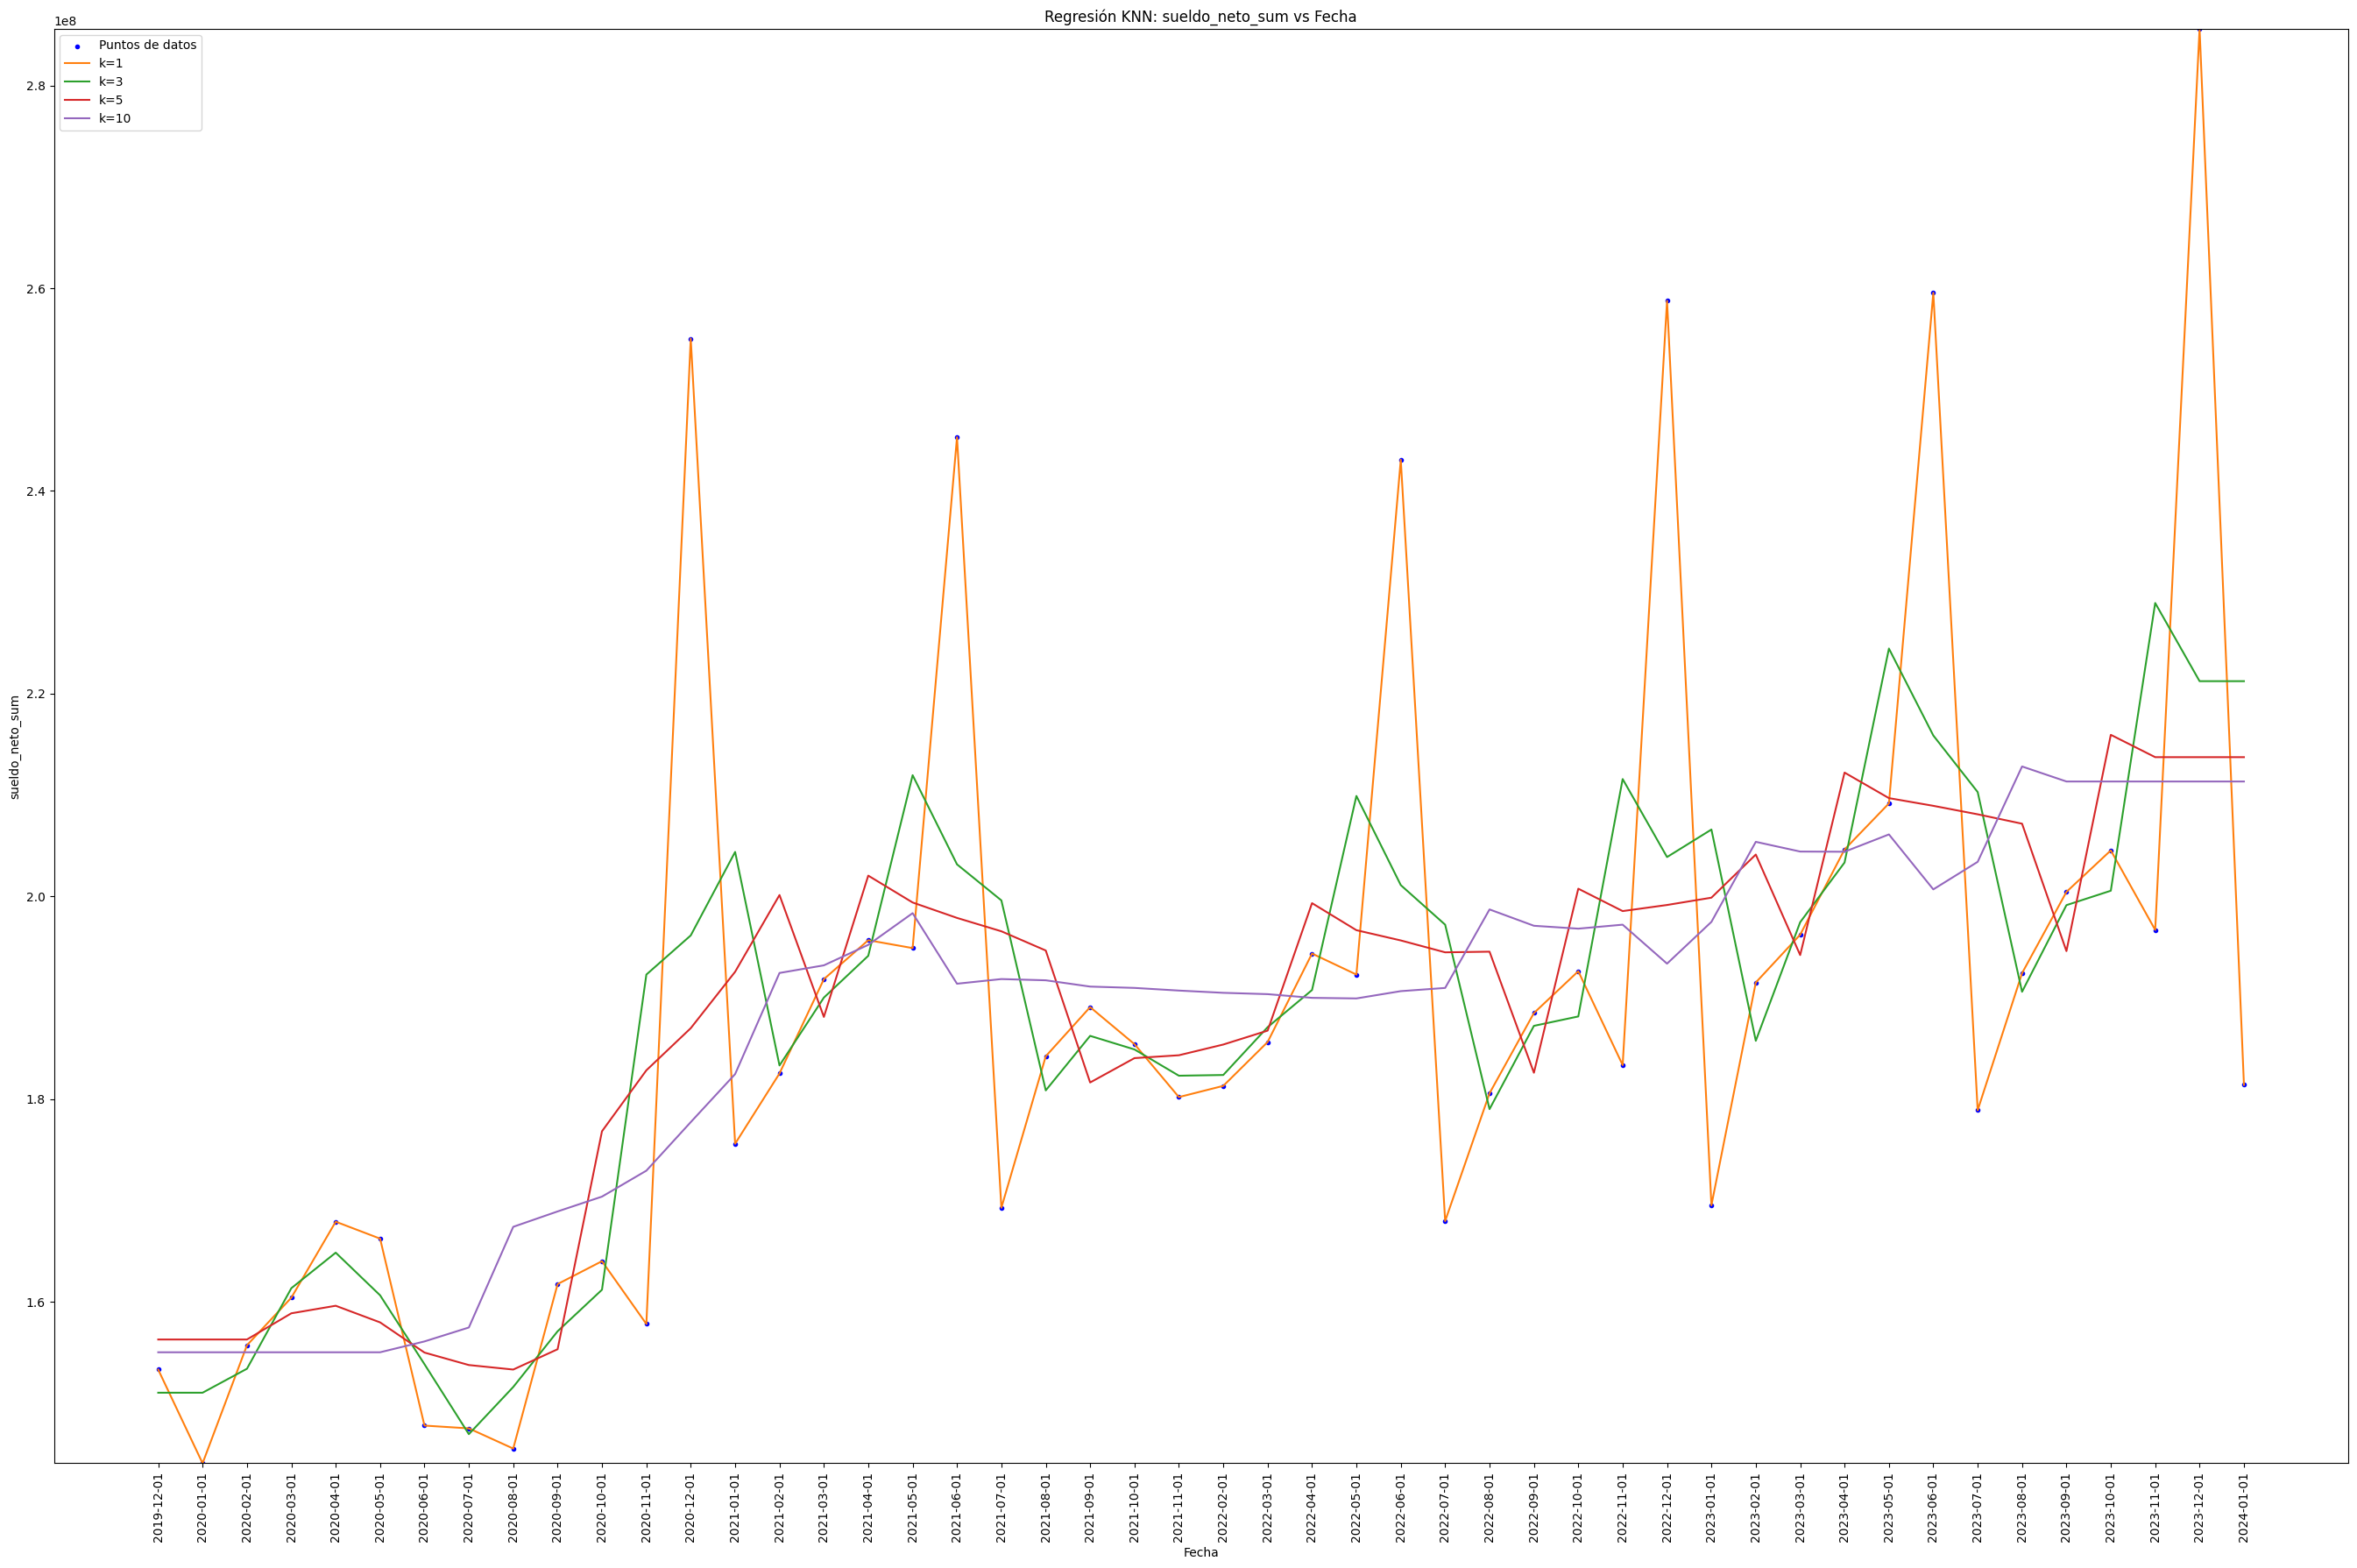

In [35]:
df_by_sal = prepare_data()  # Asumimos que esta función está definida en otra parte del código
KNN_regression_model(df_by_sal, "Fecha", "sueldo_neto_sum", [1, 3, 5, 10])

# Tree Decision
---

## Regresión de árbol de decisión

In [38]:
from typing import List
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree

def decision_tree_regression_model(df: pd.DataFrame, x: str, y: str, depths: List[int]) -> None:
    """
    Realiza una regresión con árboles de decisión de diferentes profundidades y grafica los resultados.

    Args:
    df (pd.DataFrame): El DataFrame de entrada.
    x (str): El nombre de la columna de características.
    y (str): El nombre de la columna objetivo.
    depths (List[int]): Lista de profundidades máximas para los árboles de decisión.
    """
    print("Usando regresión con árboles de decisión de sklearn")

    X = transform_variable(df, x).values.reshape(-1, 1)
    y_data = df[y]

    fig, ax = plt.subplots(figsize=(27, 18))
    
    # Graficar puntos de datos
    ax.scatter(df[x], y_data, marker='.', c='blue', label='Puntos de datos')

    # Realizar regresión con árboles de decisión para cada profundidad
    for i, max_depth in enumerate(depths):
        model = train_model(X, y_data, DecisionTreeRegressor, 
                            {'random_state': 0, 'max_depth': max_depth, 'min_samples_leaf': 5})
        y_pred = model.predict(X)
        
        ax.plot(df[x], y_pred, color=f"C{i+1}", label=f"Profundidad {max_depth}")
        
        print(f"Profundidad máxima: {max_depth}")
        print(f"R-cuadrado: {model.score(X, y_data):.4f}")
        print("--------------------")

        # Guardar el último árbol para visualización
        if i == len(depths) - 1:
            last_tree = model

    # Configurar el gráfico de regresión
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Regresión con Árboles de Decisión: {y} vs {x}')
    ax.legend(loc="upper left")
    ax.tick_params(axis='x', rotation=90)
    
    # Ajustar los límites del eje y
    ax.set_ylim([y_data.min(), y_data.max()])

    # Guardar el gráfico de regresión
    plt.tight_layout()
    plt.savefig(f'../img/regresion/decision_tree/decision_tree_regression_{y}_{x}.png')
    plt.show()
    plt.close(fig)

    # Crear y guardar la visualización del árbol
    fig, ax = plt.subplots(figsize=(21, 9))
    plot_tree(last_tree, fontsize=10, filled=True, rounded=True, feature_names=[x])
    plt.title(f'Árbol de Decisión (Profundidad {depths[-1]})')
    plt.savefig(f"../img/regresion/decision_tree/decision_tree_{y}_{x}.png", bbox_inches="tight")
    plt.show()
    plt.close(fig)

Usando regresión con árboles de decisión de sklearn
Usando DecisionTreeRegressor con parámetros {'random_state': 0, 'max_depth': 1, 'min_samples_leaf': 5}
Profundidad máxima: 1
R-cuadrado: 0.3680
--------------------
Usando DecisionTreeRegressor con parámetros {'random_state': 0, 'max_depth': 2, 'min_samples_leaf': 5}
Profundidad máxima: 2
R-cuadrado: 0.4140
--------------------
Usando DecisionTreeRegressor con parámetros {'random_state': 0, 'max_depth': 3, 'min_samples_leaf': 5}
Profundidad máxima: 3
R-cuadrado: 0.4514
--------------------
Usando DecisionTreeRegressor con parámetros {'random_state': 0, 'max_depth': 5, 'min_samples_leaf': 5}
Profundidad máxima: 5
R-cuadrado: 0.4606
--------------------
Usando DecisionTreeRegressor con parámetros {'random_state': 0, 'max_depth': 15, 'min_samples_leaf': 5}
Profundidad máxima: 15
R-cuadrado: 0.4606
--------------------


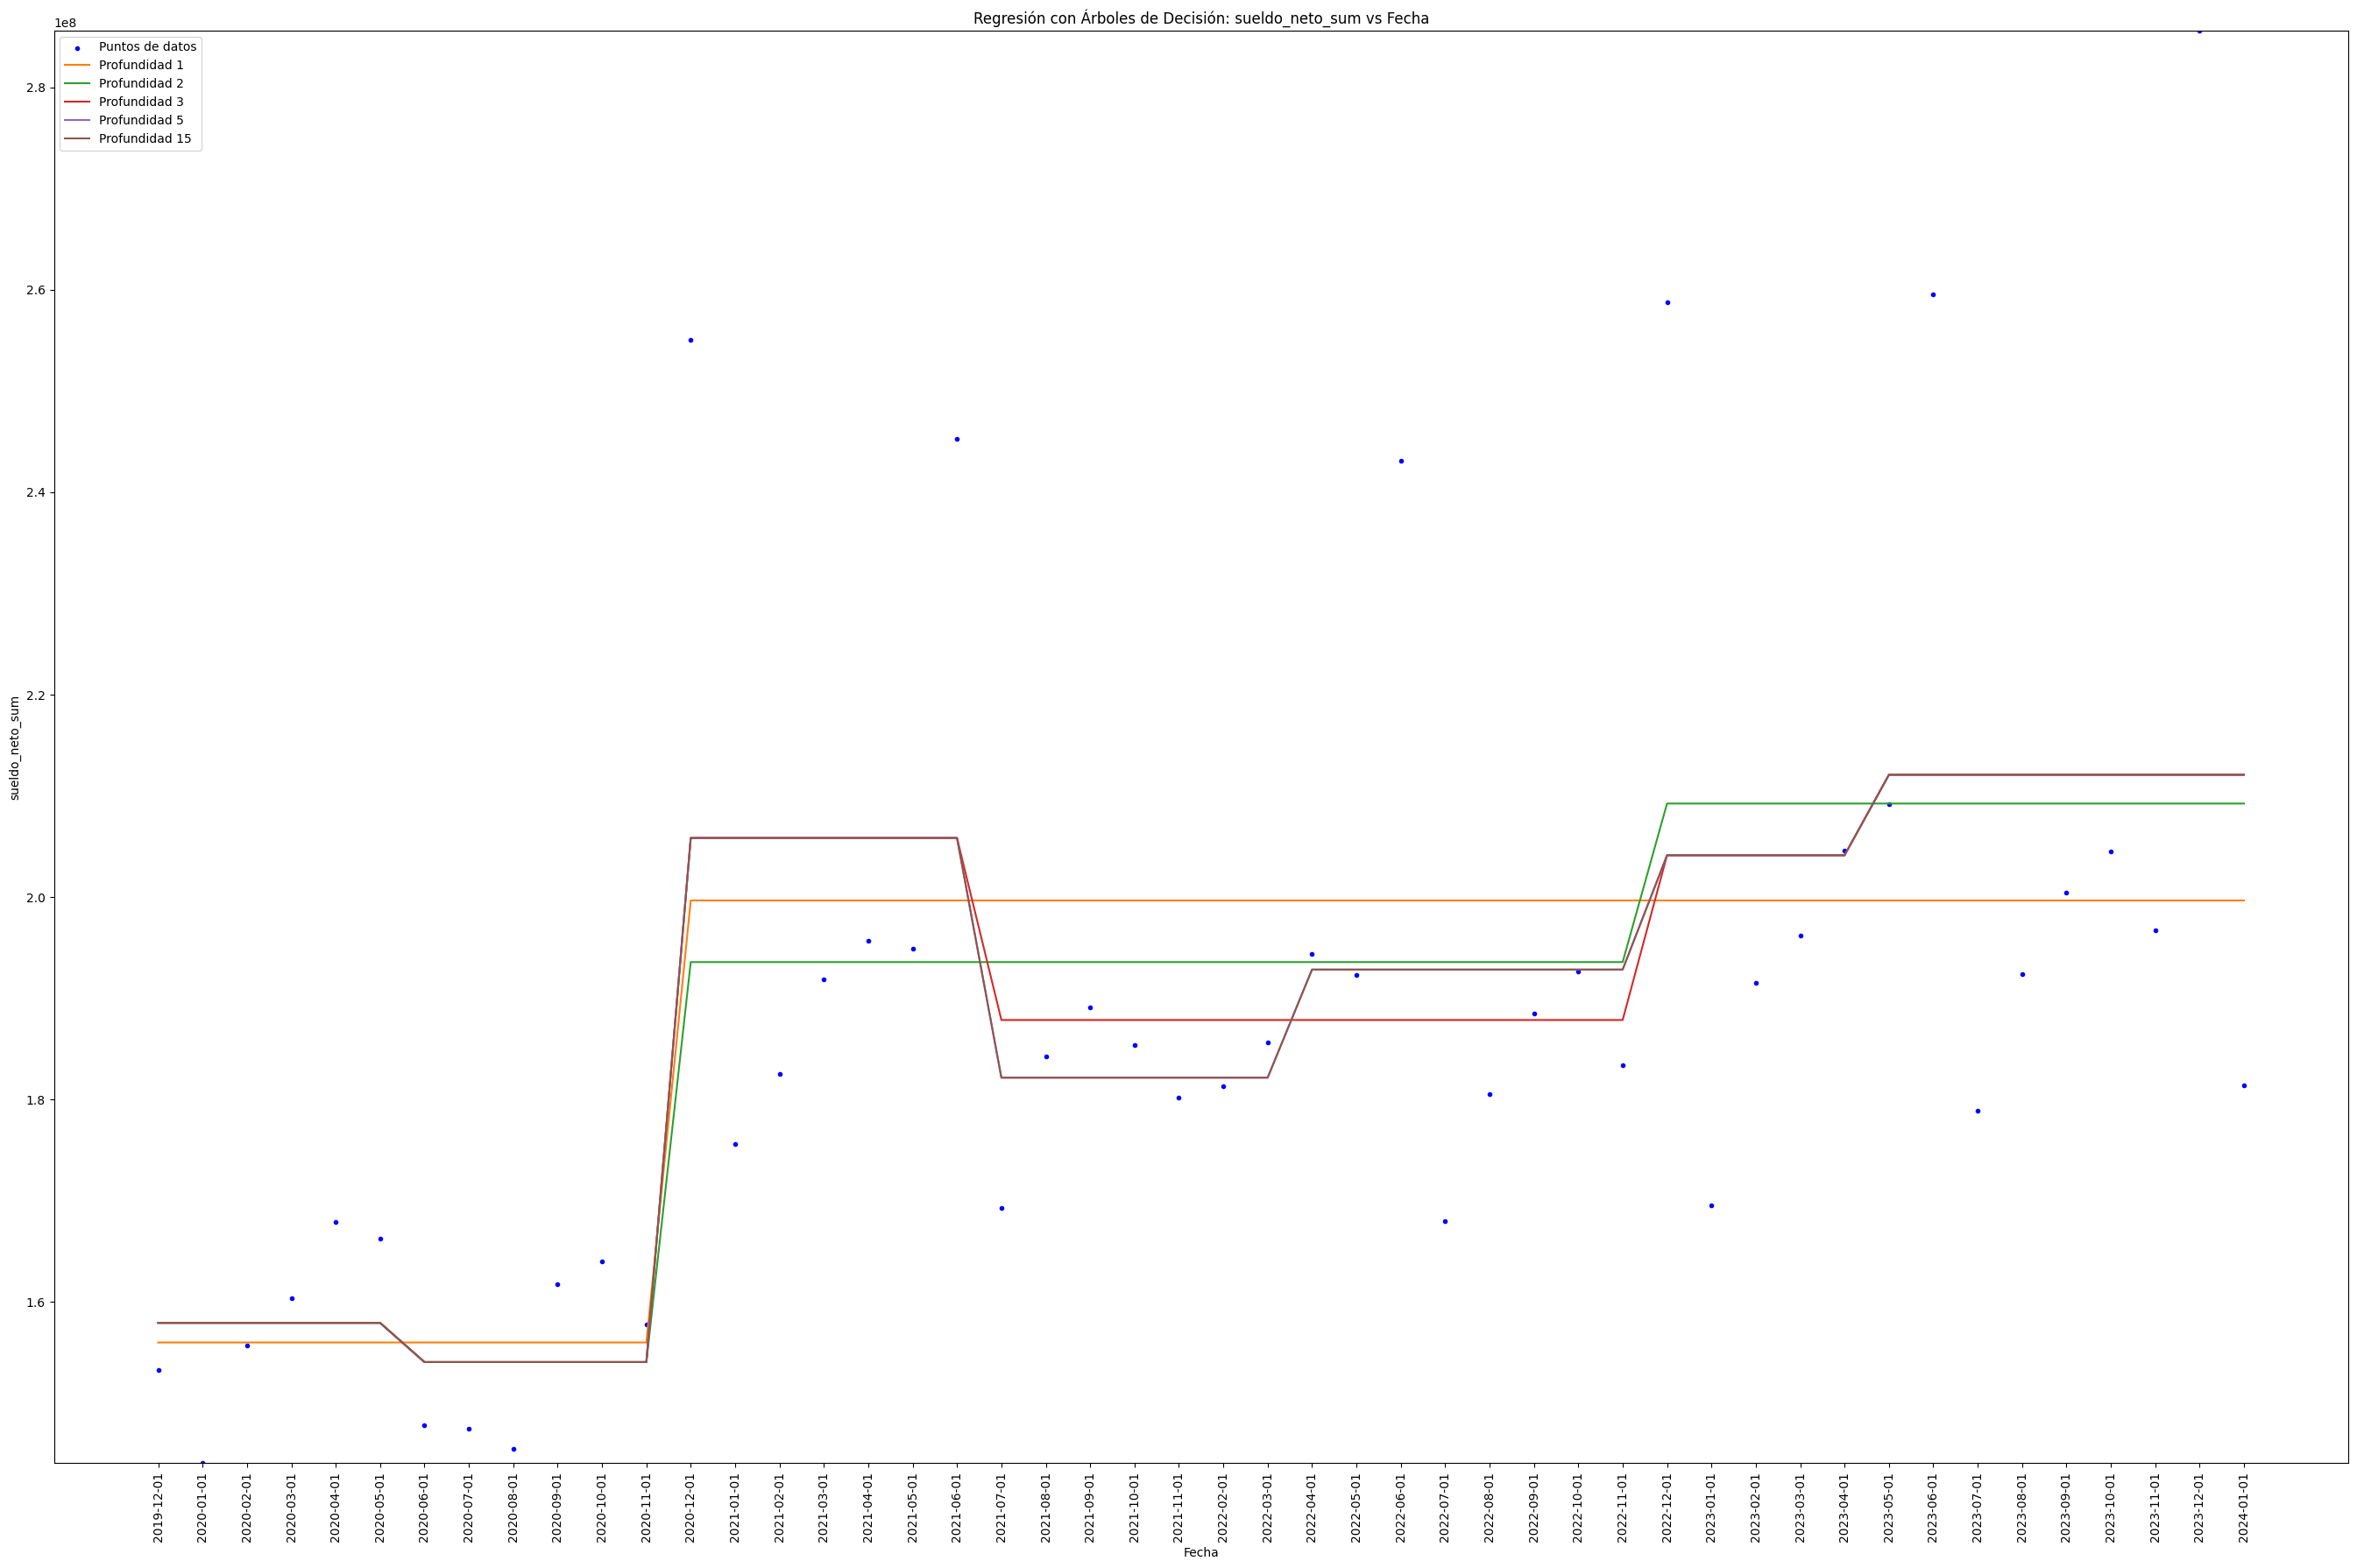

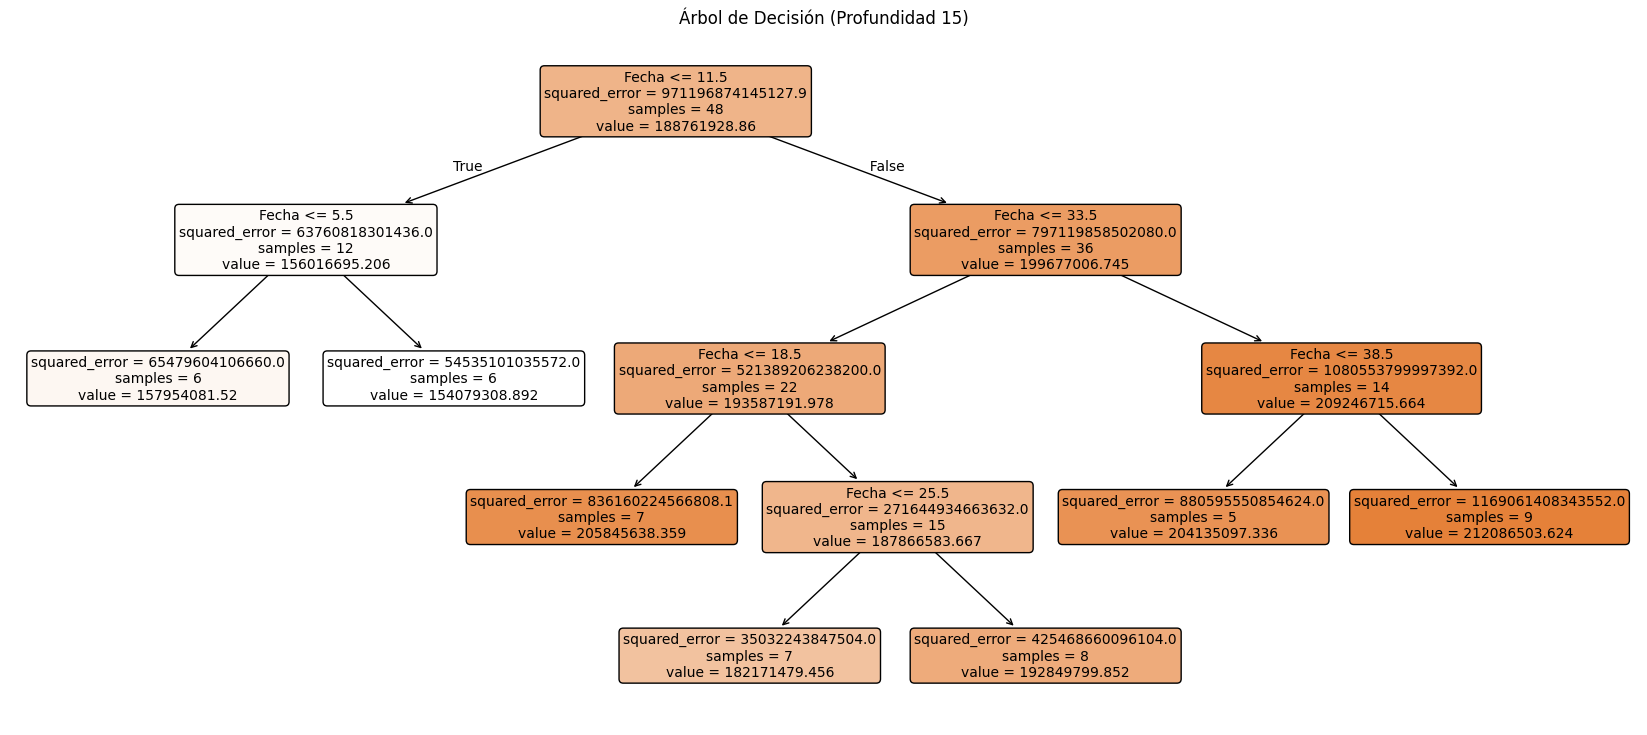

In [39]:
df_by_sal = prepare_data()  # Asumimos que esta función está definida en otra parte del código
decision_tree_regression_model(df_by_sal, "Fecha", "sueldo_neto_sum", [1, 2, 3, 5, 15])